In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

# from tropical_cyclone_dm import TropicalCycloneSequenceDataModule

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    "MVERegression": "#1f77b4",  # Blue
    "QuantileRegression": "#ff7f0e",  # Orange
    "DKLRegression": "#2ca02c",  # Green
    "LaplaceRegression": "#d62728",  # Red
    "DeepEnsembleRegression": "#9467bd",  # Purple
    "MCDropoutRegression": "#8c564b",  # Brown
    "SWAGRegression": "#e377c2",  # Pink
    "BNN_VI_ELBO_Regression": "#7f7f7f",  # Gray
    #"BNN_VI_Regression": "#bcbd25",  # Lime
    "DER": "#bcbd22",  # Lime
    "DUERegression": "#17becf",  # Teal
    "DeterministicRegression": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDRegression": "#98df8a",
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "calibration": "Calibration",
    "correlation": "Correlation",
    "nll": "NLL",
    "mace": "MACE",
    "crps": "CRPS",
    "proportion_in_0.9_interval": "Proportion in 0.9 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "MVERegression": "MVE",
    "QuantileRegression": "QR",
    "DKLRegression": "DKL",
    "LaplaceRegression": "Laplace",
    "DeepEnsembleRegression": "Deep Ensemble",
    "MCDropoutRegression": "MC Dropout",
    "SWAGRegression": "SWAG",
    "BNN_VI_ELBO_Regression": "BNN VI ELBO",
    #"BNN_VI_Regression": "BNN VI",
    "DER": "DER",
    "DUERegression": "DUE",
    "DeterministicRegression": "Deterministic",
    "ConformalQR": "CQR",
    "CARDRegression": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    # "/p/project/hai_uqmethodbox/experiment_output/keep_reg",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_subset",
    "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy",
    #"/p/project/hai_uqmethodbox/experiment_output/reg_digital_34"
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_digitaltyphoon",
    # "/p/project/hai_uqmethodbox/experiment_output/both_test",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_34",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_bnns",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_ensemble_members",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_gap"
    # "/p/project/hai_uqmethodbox/experiment_output/digital_typhoon_check"
]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
    if os.path.exists(os.path.join(os.path.dirname(file), "config.yaml"))
]


# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
#STORM_DISPLAY_ORDER = ["all", "TD", "TS", "H1", "H2", "H3", "H5"]
STORM_DISPLAY_ORDER = ["all", "TD", "H1", "H3", "H5"]

DS_SPLIT = "test"


UQ_METHOD_DISPLAY_ORDER = [
    "DeterministicRegression",
    "MVERegression",
    "DER",
    "QuantileRegression",
    "ConformalQR",
    "DeepEnsembleRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "LaplaceRegression",
    "BNN_VI_ELBO_Regression",
   # "BNN_VI_Regression",
    "DKLRegression",
    "DUERegression",
    "CARDRegression",
]

# Define the groups
UQ_METHOD_GROUPS = {
    "Deterministic": ["MVERegression", "DER"],
    "Quantile": ["QuantileRegression", "ConformalQR"],
    "Bayesian": [
        "MCDropoutRegression",
        "SWAGRegression",
        "LaplaceRegression",
        "BNN_VI_ELBO_Regression",
       # "BNN_VI_Regression",
        "DKLRegression",
        "DUERegression",
    ],
    "Ensemble": ["DeepEnsembleRegression"],
    "Diffusion": ["CARDRegression"],
}

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_QuantileRegression_02-01-2024_08-40-15-469579/preds_val.cs

## Util functions

## get normaliation params

In [4]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule

    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()


def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, "config.yaml"))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(get_normalization_params_from_df_wrapper, paths),
                total=len(paths),
            )
        )
    results = {
        k: v for result in results if result is not None for k, v in result.items()
    }
    return results


num_processes = 8
os.environ["HYDRA_FULL_ERROR"] = "1"
dir_paths = list(set([os.path.dirname(path) for path in paths]))
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(
    dir_paths, num_processes
)

  0%|          | 0/13 [00:00<?, ?it/s]

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-pac

In [5]:
NORMALIZATION_PARAMS

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_ConformalQR_02-01-2024_16-18-46-884229': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DeterministicRegression_01-31-2024_20-25-34-919831': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_QuantileRegression_02-01-2024_08-40-15-469579': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_CARDRegression_02-02-2024_10-26-30-553099': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_MCDropoutRegression_01-31-2024_20-12-11-835879': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/

## selective prediction thresholds based on validation set

In [6]:
def compute_quantile_and_save(paths: list[str], quantile: float = 0.9):
    selective_pred_dict = {}
    for path in paths:
        # assert "val" in path
        df = pd.read_csv(path)

        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            df["target"] = df["target"] * TARGET_STD + TARGET_MEAN
            # threshold = np.quantile(df['pred_uct'], quantile)
            df["storm_category"] = pd.cut(
                df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
            )
            if SELECTIVE_PROCEDURE == "absolute":
                # create a dict over all storm categories and fill values with absolute threshold
                thresholds = {category: SELECTIVE_THRESH for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                method_threshold = df["pred_uct"].quantile(quantile)
                thresholds = {category: method_threshold for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "category_conditional":
                thresholds = (
                    df.groupby("storm_category", observed=False)["pred_uct"]
                    .quantile(quantile)
                    .to_dict()
                )
        else:
            continue

        selective_pred_dict[os.path.dirname(path)] = thresholds
    return selective_pred_dict


dir_paths = [path for path in paths]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths, 0.8)
SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_QuantileRegression_02-01-2024_08-40-15-469579': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DeepEnsembleRegression_02-02-2024_15-09-32-001250': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DUERegression_02-01-2024_08-40-15-469591': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3'

In [7]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("preds.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
1,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
2,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
5,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
6,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
7,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
8,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
9,DeepEnsembleRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...


In [8]:
empty_result = {
    "accuracy": {
        "mae": np.nan,
        "rmse": np.nan,
        "mdae": np.nan,
        "marpd": np.nan,
        "r2": np.nan,
        "corr": np.nan,
    },
    "avg_calibration": {"rms_cal": np.nan, "ma_cal": np.nan, "miscal_area": np.nan},
    "sharpness": {"sharp": np.nan},
    "scoring_rule": {
        "nll": np.nan,
        "crps": np.nan,
        "check": np.nan,
        "interval": np.nan,
    },
}


def compute_metrics_for_predictions(
    csv_path: str, selective_pred: bool, normalized: bool = False
) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = (
        NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_mean"],
        NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_std"],
    )

    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    # Apply the storm category
    pred_df["storm_category"] = pd.cut(
        pred_df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
    )
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

    if "pred_uct" in pred_df.columns:
        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)]]
            grouped = pred_df.groupby("storm_category", observed=False)

            # Apply the selective prediction filter to each group
            pred_df = grouped.apply(
                lambda group: group[
                    group["pred_uct"]
                    <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)][group.name]
                ]
            )

            # Reset the index of the DataFrame
            pred_df.reset_index(drop=True, inplace=True)
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category", observed=False)[
                "pred"
            ].count()

        if len(pred_df) > 0:
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = [
            "scoring_rule",
            "avg_calibration",
            "sharpness",
            "accuracy",
        ]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {
            "accuracy": uct.metrics.get_all_accuracy_metrics(
                pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze()
            )
        }

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [
            f"{inner_key}"
            for outer_key, inner_dict in empty_result.items()
            for inner_key in inner_dict.keys()
        ]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan

    split_name = csv_path.split(os.sep)[-1].split(".")[0]
    if split_name == "preds":
        split_name = "preds_test"
    df["split"] = split_name
    df["pred_path"] = csv_path

    # count
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[count_df.columns.intersection(CLASS_LABELS)]
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)
    return df

In [9]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_uncertainty_df(overview_df):
    def parallel_process(
        paths: List[str], num_processes: int, selective_pred: bool, normalised: bool
    ):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        # result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        results = pool.starmap(
            compute_metrics_for_predictions_wrapper,
            [(path, selective_pred, normalised) for path in paths],
        )
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df["pred_path"].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(
        paths, num_processes, selective_pred=False, normalised=False
    )
    selective_df = parallel_process(
        paths, num_processes, selective_pred=True, normalised=False
    )

    # merge model name column
    uqmetric_df = pd.merge(
        left=uqmetric_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )
    selective_df = pd.merge(
        left=selective_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics


/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

 (1/n) Calculating accuracy metrics


/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

 (1/n) Calculating accuracy metrics


/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(


 (1/n) Calculating accuracy metrics


/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_10930/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

(          nll       crps     check   interval   rms_cal    ma_cal  \
 0    3.949773   6.848777  3.457718  35.533872  0.064776  0.056251   
 1    3.948189   6.840202  3.453518  35.380967  0.065011  0.055761   
 2    3.861324   6.293967  3.177965  32.147211  0.082573  0.072472   
 3   58.101242   6.685429  3.352030  61.873531  0.479794  0.416516   
 4   52.603906   6.275765  3.147070  57.680836  0.477091  0.413778   
 5    4.356502   1.424309  0.717594   9.593383  0.273263  0.242259   
 6    3.799299   6.286635  3.173897  31.935730  0.011250  0.009324   
 7    3.727799   5.819242  2.938107  29.226523  0.015484  0.013569   
 8    3.676418   5.581838  2.818391  27.804536  0.018004  0.016157   
 9    3.882303   6.062070  3.060786  32.794905  0.204953  0.183441   
 10   4.153002   8.832340  4.459720  44.061580  0.065054  0.050795   
 11   3.763829   4.616343  2.330645  27.934239  0.338936  0.300499   
 12   3.792674   5.836497  2.946756  30.203008  0.062632  0.055023   
 13   3.728134   5.4

# Overview Function

In [10]:
with pd.option_context("display.max_colwidth", None):
    display(
        uq_metric_df[uq_metric_df["uqmethod"] == "DUERegression"][
            ["pred_path", "split", "rmse", "nll", "crps", "sharp"]
        ]
    )

,pred_path,split,rmse,nll,crps,sharp
12,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DUERegression_02-01-2024_08-40-15-469591/preds_val.csv,preds_val,10.661471,3.792674,5.836497,11.140982
13,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DUERegression_02-01-2024_08-40-15-469591/preds_test.csv,preds_test,9.947999,3.728134,5.432176,11.029723
14,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DUERegression_02-01-2024_08-40-15-469591/preds_train.csv,preds_train,2.769908,3.348145,2.842395,11.117891


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [11]:
diff_df = pd.DataFrame()

# Iterate over each column in the dataframes
for column in uq_metric_df.columns:
    # Check if the column contains numerical values
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        # Assign the difference to the new dataframe
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        # If the column contains non-numerical values, assign the values from df1 to the new dataframe
        diff_df[column] = uq_metric_df[column]

display(
    diff_df[diff_df["split"] == "preds_train"][
        ["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]
    ]
)

,uqmethod,split,nll,sharp,mae,rmse,pred_path
2,DKLRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
5,BNN_VI_ELBO_Regression,preds_train,0.000000,0.000000,2.220446e-16,0.000000,/p/project/hai_uqmethodbox/experiment_output/m...
8,QuantileRegression,preds_train,0.346047,3.653151,2.535455e+00,3.330684,/p/project/hai_uqmethodbox/experiment_output/m...
11,DeepEnsembleRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
14,DUERegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
17,DeterministicRegression,preds_train,NaN,NaN,0.000000e+00,0.000000,/p/project/hai_uqmethodbox/experiment_output/m...
20,ConformalQR,preds_train,0.609348,6.305140,4.407983e+00,5.936535,/p/project/hai_uqmethodbox/experiment_output/m...
23,SWAGRegression,preds_train,0.587144,5.668706,3.855175e+00,5.310257,/p/project/hai_uqmethodbox/experiment_output/m...
26,LaplaceRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
29,CARDRegression,preds_train,0.115037,2.790842,1.100750e+00,1.303741,/p/project/hai_uqmethodbox/experiment_output/m...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'DKLRegression'),
  Text(1, 0, 'BNN_VI_ELBO_Regression'),
  Text(2, 0, 'QuantileRegression'),
  Text(3, 0, 'DeepEnsembleRegression'),
  Text(4, 0, 'DUERegression'),
  Text(5, 0, 'DeterministicRegression'),
  Text(6, 0, 'ConformalQR'),
  Text(7, 0, 'SWAGRegression'),
  Text(8, 0, 'LaplaceRegression'),
  Text(9, 0, 'CARDRegression'),
  Text(10, 0, 'MCDropoutRegression'),
  Text(11, 0, 'DER'),
  Text(12, 0, 'MVERegression')])

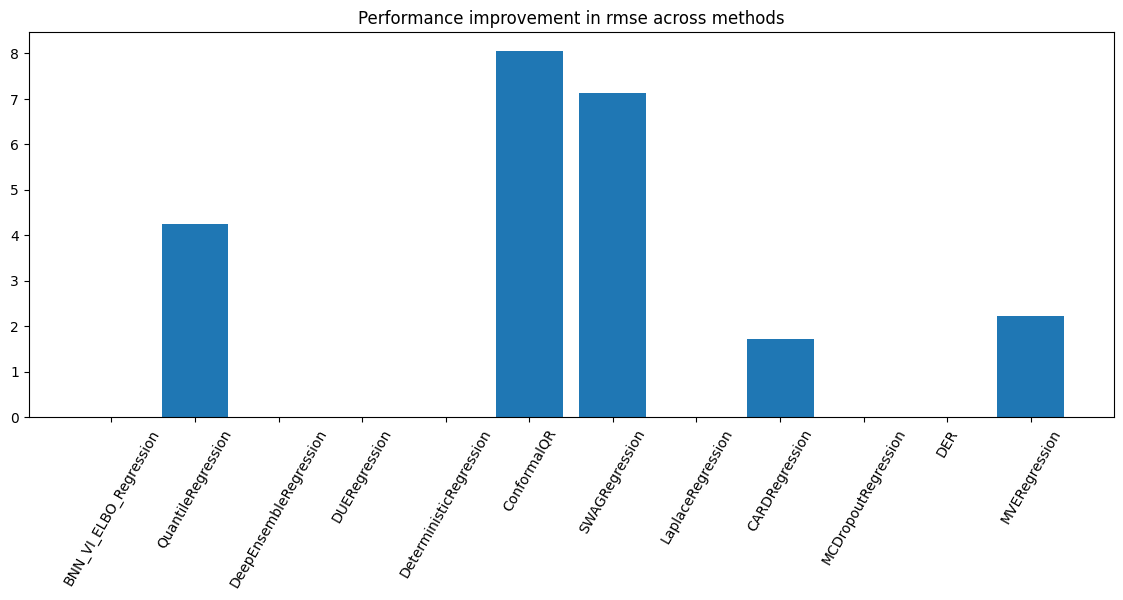

In [12]:
metric = "rmse"
diff_train = diff_df[diff_df["split"] == "preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"] == "preds_val"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

In [13]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,3.949773,6.848777,3.457718,35.533872,0.064776,0.056251,0.056815,13.124807,9.342685,12.698880,...,/p/project/hai_uqmethodbox/experiment_output/m...,3217,4521,1090,433,588,419,68,10336,DKLRegression
1,3.948189,6.840202,3.453518,35.380967,0.065011,0.055761,0.056318,13.164921,9.340257,12.586209,...,/p/project/hai_uqmethodbox/experiment_output/m...,16670,18662,4071,1572,1574,939,147,43635,DKLRegression
2,3.861324,6.293967,3.177965,32.147211,0.082573,0.072472,0.073201,13.120582,8.623980,11.356123,...,/p/project/hai_uqmethodbox/experiment_output/m...,18029,24483,6145,2662,2660,2041,328,56348,DKLRegression
3,58.101242,6.685429,3.352030,61.873531,0.479794,0.416516,0.420723,0.950247,7.160022,9.891810,...,/p/project/hai_uqmethodbox/experiment_output/m...,3217,4521,1090,433,588,419,68,10336,BNN_VI_ELBO_Regression
4,52.603906,6.275765,3.147070,57.680836,0.477091,0.413778,0.417958,0.943718,6.744963,9.274502,...,/p/project/hai_uqmethodbox/experiment_output/m...,16670,18662,4071,1572,1574,939,147,43635,BNN_VI_ELBO_Regression
5,4.356502,1.424309,0.717594,9.593383,0.273263,0.242259,0.244706,0.888683,1.769174,2.404192,...,/p/project/hai_uqmethodbox/experiment_output/m...,18029,24483,6145,2662,2660,2041,328,56348,BNN_VI_ELBO_Regression
6,3.799299,6.286635,3.173897,31.935730,0.011250,0.009324,0.009407,10.764476,8.758051,12.056662,...,/p/project/hai_uqmethodbox/experiment_output/m...,3217,4521,1090,433,588,419,68,10336,QuantileRegression
7,3.727799,5.819242,2.938107,29.226523,0.015484,0.013569,0.013706,10.136679,8.145264,10.954583,...,/p/project/hai_uqmethodbox/experiment_output/m...,16670,18662,4071,1572,1574,939,147,43635,QuantileRegression
8,3.676418,5.581838,2.818391,27.804536,0.018004,0.016157,0.016316,10.689566,7.831585,10.398647,...,/p/project/hai_uqmethodbox/experiment_output/m...,18029,24483,6145,2662,2660,2041,328,56348,QuantileRegression
9,3.882303,6.062070,3.060786,32.794905,0.204953,0.183441,0.185294,16.725278,7.621405,10.694745,...,/p/project/hai_uqmethodbox/experiment_output/m...,3221,4517,1089,433,582,426,67,10335,DeepEnsembleRegression


The number of samples being removed per category as a percentage.

In [14]:
sample_remain_pct = (
    uq_metric_df[CLASS_LABELS + ["count_total"]]
    - selective_df[CLASS_LABELS + ["count_total"]]
) / uq_metric_df[CLASS_LABELS + ["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])
print(sample_remain_pct)

                  UQ Method        split        TD        TS        H1  \
0             DKLRegression    preds_val  1.000000  1.000000  1.000000   
1             DKLRegression   preds_test  1.000000  1.000000  1.000000   
2             DKLRegression  preds_train  1.000000  1.000000  1.000000   
3    BNN_VI_ELBO_Regression    preds_val  0.000000  0.000000  0.000000   
4    BNN_VI_ELBO_Regression   preds_test  0.000000  0.000000  0.000000   
5    BNN_VI_ELBO_Regression  preds_train  0.000000  0.000000  0.000000   
6        QuantileRegression    preds_val  0.271993  0.719973  0.925688   
7        QuantileRegression   preds_test  0.208518  0.680313  0.946942   
8        QuantileRegression  preds_train  0.257252  0.708328  0.948251   
9    DeepEnsembleRegression    preds_val  1.000000  1.000000  1.000000   
10   DeepEnsembleRegression   preds_test  1.000000  1.000000  1.000000   
11   DeepEnsembleRegression  preds_train  1.000000  1.000000  1.000000   
12            DUERegression    preds_v

                  UQ Method storm_category     value
0             DKLRegression             TD  1.000000
1    BNN_VI_ELBO_Regression             TD  0.000000
2        QuantileRegression             TD  0.208518
3    DeepEnsembleRegression             TD  1.000000
4             DUERegression             TD  1.000000
..                      ...            ...       ...
99        LaplaceRegression    count_total  1.000000
100          CARDRegression    count_total  0.395073
101     MCDropoutRegression    count_total  0.999862
102                     DER    count_total  1.000000
103           MVERegression    count_total  0.379466

[104 rows x 3 columns]
                  UQ Method storm_category     value
0             DKLRegression             TD  1.000000
1    BNN_VI_ELBO_Regression             TD  0.000000
2        QuantileRegression             TD  0.208518
3    DeepEnsembleRegression             TD  1.000000
4             DUERegression             TD  1.000000
5   DeterministicRegre

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

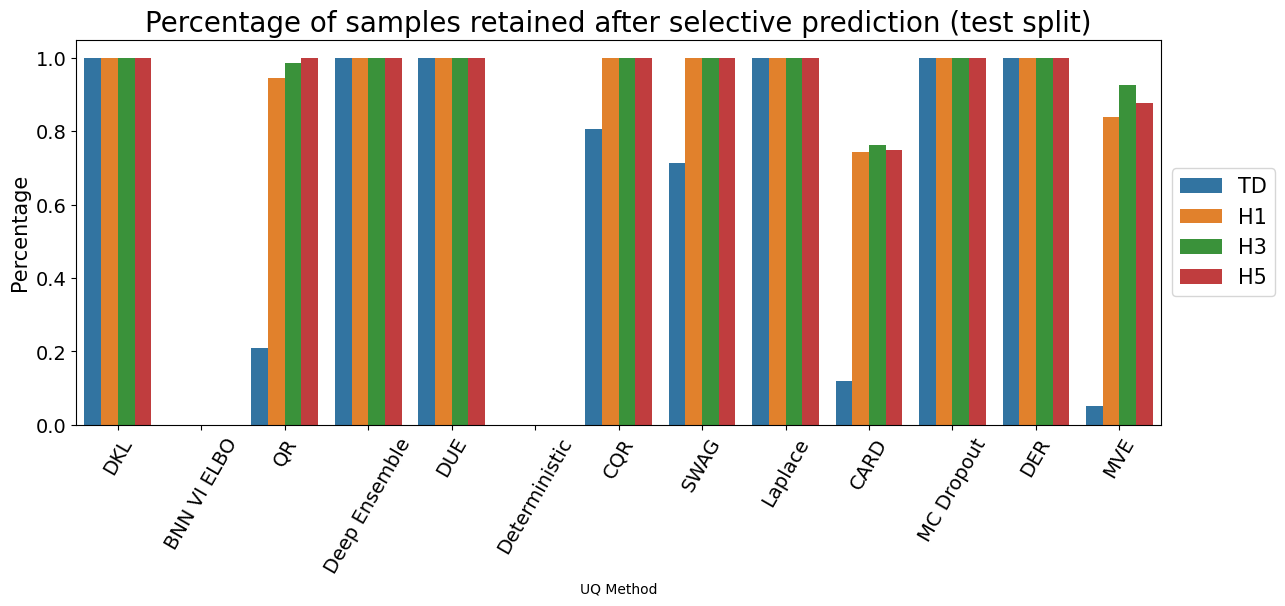

In [15]:
def plot_sample_percentage(sample_remain_pct, split_type):
    # Filter the DataFrame based on the split type
    count = sample_remain_pct[
        sample_remain_pct["split"] == f"preds_{split_type}"
    ].reset_index(drop=True)

    # Melt the DataFrame to long format
    count = pd.melt(
        count,
        id_vars="UQ Method",
        value_vars=CLASS_LABELS + ["count_total"],
        var_name="storm_category",
    )
    print(count)
    count = count[count["storm_category"].isin(STORM_DISPLAY_ORDER)]

    print(count)
    # Create the bar plot
    fig, ax = plt.subplots(1)
    sns.barplot(x="UQ Method", y="value", hue="storm_category", data=count, ax=ax)
    plt.ylabel("Percentage", fontsize=15)
    plt.title(
        f"Percentage of samples retained after selective prediction ({split_type} split)",
        fontsize=20,
    )
    plt.xticks(rotation=60, fontsize=14)
    plt.yticks(fontsize=14)

    # Set the x-tick labels using the VAR_TO_PLOT_LABEL dictionary
    ax.set_xticklabels(
        [VAR_TO_PLOT_LABEL[label.get_text()] for label in ax.get_xticklabels()]
    )

    # Increase the size of the legend and place it next to the plot
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop={"size": 15})

    plt.show()


# Call the function with 'train' or 'val' as the argument
plot_sample_percentage(sample_remain_pct, DS_SPLIT)

# All preds in a single DF

In [16]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    if row["split"] == "preds.csv":
        pred_df["split"] = "preds_test"
    else:
        pred_df["split"] = row["split"].split(".")[0]

    pred_df["pred_path"] = row["pred_path"]
    all_test_pred_df.append(pred_df)

from scipy import stats

# test_df = overview_df[overview_df["split"]=="preds"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)


def get_normalization_params(group):
    pred_path = group["pred_path"].iloc[0]
    TARGET_MEAN, TARGET_STD = (
        NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_mean"],
        NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_std"],
    )
    group["target_mean"] = TARGET_MEAN
    group["target_std"] = TARGET_STD
    return group


all_test_pred_df = all_test_pred_df.groupby("pred_path").apply(get_normalization_params)

# normalize
all_test_pred_df["pred"] = (
    all_test_pred_df["pred"] * all_test_pred_df["target_std"]
) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (
    all_test_pred_df["target"] * all_test_pred_df["target_std"]
) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = (
    all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]
)

all_test_pred_df["storm_category"] = pd.cut(
    all_test_pred_df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"]) ** 2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(
    all_test_pred_df["pred"] - all_test_pred_df["target"],
    scale=all_test_pred_df["pred_uct"],
)

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df["date"] = pd.to_datetime(
    all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
)

all_test_pred_df = all_test_pred_df.reset_index(drop=True)
all_test_pred_df = all_test_pred_df.dropna(subset=["mse", "mae"], how="any")
all_test_pred_df

/tmp/ipykernel_10930/1574974368.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_test_pred_df = all_test_pred_df.groupby("pred_path").apply(get_normalization_params)


,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,storm_id,relative_time,ocean,...,upper_quant,aleatoric_uct,wind_speed,target_mean,target_std,storm_category,mse,mae,nll,date
0,27.138703,0.951457,0.035508,32.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,307798.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,34.354784,5.861295,19.844060,NaT
1,26.117810,0.866908,0.032353,32.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,309598.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,47.364519,6.882189,32.288208,NaT
2,25.733327,0.769795,0.028729,31.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,313198.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,39.271179,6.266672,33.792818,NaT
3,24.459123,0.861460,0.032150,31.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,314998.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,56.864810,7.540876,39.082540,NaT
4,24.719387,0.956099,0.035682,30.999998,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,316799.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,39.446074,6.280611,22.449910,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434141,62.394465,15.567978,0.030787,71.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.580181,NaN,50.344008,26.795277,H1,74.055234,8.605535,3.816933,NaT
1434142,99.349355,14.018799,0.037920,110.000001,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.521806,NaN,50.344008,26.795277,H3,113.436255,10.650646,3.847940,NaT
1434143,32.555181,11.664079,0.037955,42.999998,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.433646,NaN,50.344008,26.795277,TS,109.094209,10.444817,3.776385,NaT
1434144,42.211941,14.110436,0.032120,33.999999,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.525621,NaN,50.344008,26.795277,TS,67.436004,8.211943,3.735202,NaT


In [17]:
# Filter for specific method
cqr = all_test_pred_df[all_test_pred_df["uqmethod"] == "ConformalQR"]
qr = all_test_pred_df[all_test_pred_df["uqmethod"] == "QuantileRegression"]

# Filter for specific split
cqr_split = cqr[cqr["split"] == f"preds_{DS_SPLIT}"]
qr_split = qr[qr["split"] == f"preds_{DS_SPLIT}"]

# Sort rows
cqr_sorted = cqr_split.sort_values(by="index")
qr_sorted = qr_split.sort_values(by="index")

In [18]:
cqr_sorted[["index", "pred_uct"]]

,index,pred_uct
220638,0.0,8.490813
220639,1.0,8.573580
220640,2.0,9.378245
220641,3.0,9.020789
220642,4.0,8.645615
...,...,...
264268,43630.0,8.002889
264269,43631.0,7.593457
264270,43632.0,6.782066
264271,43633.0,7.187809


In [19]:
qr_sorted[["index", "pred_uct"]]

,index,pred_uct
1213508,0.0,4.401961
1213509,1.0,4.484729
1213510,2.0,5.289393
1213511,3.0,4.931938
1213512,4.0,4.556763
...,...,...
1257138,43630.0,3.914038
1257139,43631.0,3.504606
1257140,43632.0,2.693214
1257141,43633.0,3.098957


In [20]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]["uqmethod"].unique()

array(['DeterministicRegression'], dtype=object)

In [21]:
laplace_df = all_test_pred_df[all_test_pred_df["uqmethod"] == "LaplaceRegression"]
abs(laplace_df["target_mean"] - laplace_df["target"]).std() / 26.795276641845703

0.5938520065564588

## selective prediction

In [22]:
OG_SELECTIVE_PROCEDURE = "method"


def compute_quantile_and_save(
    paths: list[str],
    quantiles: list[float] = [
        0.95,
        0.9,
        0.85,
        0.8,
        0.75,
        0.7,
        0.65,
        0.6,
        0.55,
        0.5,
        0.45,
        0.4,
        0.35,
        0.3,
        0.25,
        0.2,
        0.15,
        0.1,
        0.05,
    ],
):
    selective_pred_dict = {}
    for path in paths:
        # assert "val" in path
        df = pd.read_csv(path)
        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            if OG_SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                quant_dict = {
                    quantile: df["pred_uct"].quantile(quantile)
                    for quantile in quantiles
                }
        selective_pred_dict[os.path.dirname(path)] = quant_dict
    return selective_pred_dict


dir_paths = [path for path in paths if "val" in path]
OG_SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths)
OG_SELECTIVE_PRED_DICT

from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Initialize an empty DataFrame to store the RMSE
rmse_df = pd.DataFrame(columns=["pred_path", "threshold", "RMSE"])

# Iterate over each unique "pred_path" in all_test_pred_df
for pred_path in tqdm(all_test_pred_df["pred_path"].unique()):
    exp_path = os.path.dirname(pred_path)
    # split = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'split'].iloc[0]
    # uq_method = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'uqmethod'].iloc[0]
    # Check if the current "pred_path" is in SELECTIVE_PRED_DICT
    if "DeterministicRegression" in exp_path:
        continue
    if exp_path in OG_SELECTIVE_PRED_DICT:
        path_df = all_test_pred_df[(all_test_pred_df["pred_path"] == pred_path)]
        # compute rmse on full df
        full_rmse = mean_squared_error(
            path_df["pred"], path_df["target"], squared=False
        )
        row_df = pd.DataFrame(
            {"pred_path": [pred_path], "threshold": [1.0], "RMSE": [full_rmse]}
        )
        rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
        # Iterate over each threshold
        for threshold, value in tqdm(OG_SELECTIVE_PRED_DICT[exp_path].items()):

            filtered_df = path_df[(path_df["pred_uct"] <= value)]
            # print(filtered_df.shape)
            if len(filtered_df) != 0:
                # Compute the RMSE for the filtered DataFrame
                rmse = mean_squared_error(
                    filtered_df["pred"], filtered_df["target"], squared=False
                )

                # Create a new DataFrame for the current row
                row_df = pd.DataFrame(
                    {"pred_path": [pred_path], "threshold": [threshold], "RMSE": [rmse]}
                )
            else:
                row_df = pd.DataFrame(
                    {
                        "pred_path": [pred_path],
                        "threshold": [threshold],
                        "RMSE": [np.nan],
                    }
                )

            # Concatenate the new row with rmse_df
            rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)

meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])
rmse_df = rmse_df.merge(
    meta_df[["pred_path", "split", "uqmethod"]], on="pred_path", how="left"
)

  0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipykernel_10930/1415361777.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
100%|██████████| 19/19 [00:00<00:00, 583.46it/s]


100%|██████████| 39/39 [00:04<00:00,  8.15it/s]


In [23]:
OG_SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876': {0.95: 15.057757007129197,
  0.9: 13.782237163704316,
  0.85: 13.312188581210199,
  0.8: 13.093528333285075,
  0.75: 12.965642915210598,
  0.7: 12.89624328096157,
  0.65: 12.855224534554305,
  0.6: 12.828756159630343,
  0.55: 12.811829448979054,
  0.5: 12.797914527497086,
  0.45: 12.787029548984814,
  0.4: 12.777998937638577,
  0.35: 12.770719196699783,
  0.3: 12.76407785324283,
  0.25: 12.758069950141415,
  0.2: 12.752056821960927,
  0.15: 12.746878366668556,
  0.1: 12.742011674427651,
  0.05: 12.73705253848004},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445': {0.95: 1.3605450230567977,
  0.9: 1.2467236287848629,
  0.85: 1.171988572509001,
  0.8: 1.1153978980687316,
  0.75: 1.0644910378508463,
  0.7: 1.0207928708939762,
  0.65: 0.9841459883415814,
  0.6: 0.9525614705426252,
  0.5

In [24]:
rmse_df

,pred_path,threshold,RMSE,split,uqmethod
0,/p/project/hai_uqmethodbox/experiment_output/m...,1.00,9.274502,preds_test,BNN_VI_ELBO_Regression
1,/p/project/hai_uqmethodbox/experiment_output/m...,0.95,9.103309,preds_test,BNN_VI_ELBO_Regression
2,/p/project/hai_uqmethodbox/experiment_output/m...,0.90,8.950439,preds_test,BNN_VI_ELBO_Regression
3,/p/project/hai_uqmethodbox/experiment_output/m...,0.85,8.821426,preds_test,BNN_VI_ELBO_Regression
4,/p/project/hai_uqmethodbox/experiment_output/m...,0.80,8.656174,preds_test,BNN_VI_ELBO_Regression
...,...,...,...,...,...
715,/p/project/hai_uqmethodbox/experiment_output/m...,0.25,5.439367,preds_val,SWAGRegression
716,/p/project/hai_uqmethodbox/experiment_output/m...,0.20,4.922235,preds_val,SWAGRegression
717,/p/project/hai_uqmethodbox/experiment_output/m...,0.15,4.324040,preds_val,SWAGRegression
718,/p/project/hai_uqmethodbox/experiment_output/m...,0.10,3.737724,preds_val,SWAGRegression


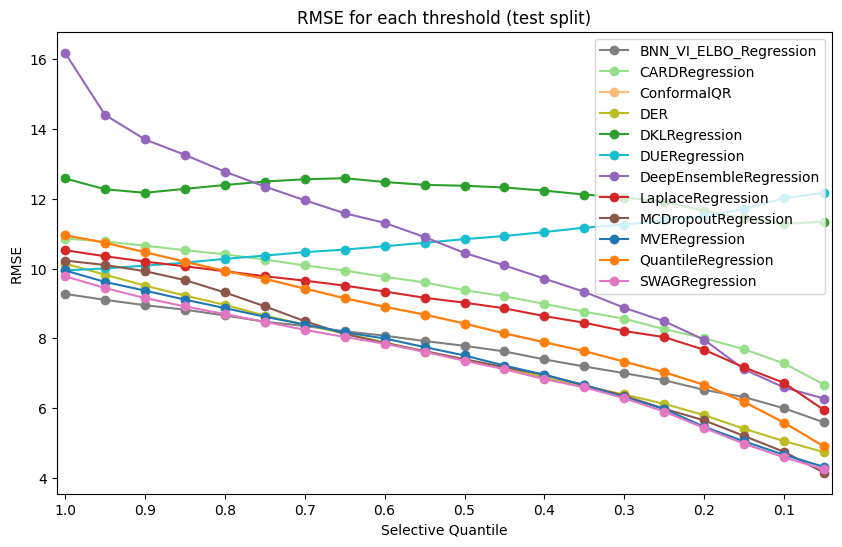

In [25]:
import matplotlib.pyplot as plt


def plot_rmse(rmse_df, DS_SPLIT):
    # Filter the DataFrame for the given DS_SPLIT
    split_df = rmse_df[rmse_df["split"] == f"preds_{DS_SPLIT}"]

    # Get the unique pred_paths
    pred_paths = split_df["pred_path"].unique()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot a line for each pred_path
    for pred_path in pred_paths:
        path_df = split_df[split_df["pred_path"] == pred_path]
        method = path_df["uqmethod"].iloc[0]
        path_df = path_df.sort_values("threshold", ascending=False)
        plt.plot(
            path_df["threshold"],
            path_df["RMSE"],
            "o-",
            label=method,
            color=color_palette[method],
        )

    # Add labels and title
    plt.xlim(max(path_df["threshold"]) + 0.01, min(path_df["threshold"]) - 0.01)
    start, end = plt.xlim()
    plt.xticks(
        np.arange(max(path_df["threshold"]), min(path_df["threshold"]), step=-0.1)
    )  # adjust the step size as needed
    plt.xlabel("Selective Quantile")
    plt.ylabel("RMSE")
    plt.title(f"RMSE for each threshold ({DS_SPLIT} split)")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


# Call the function
plot_rmse(rmse_df, "test")

## Dataframe with Metrics per Category

In [26]:
import uncertainty_toolbox.metrics_calibration as uct_cal
import uncertainty_toolbox.metrics_scoring_rule as uct_score


def compute_metrics(all_test_pred_df, quantile=0.95):
    group_cols = ["uqmethod", "pred_path", "storm_category"]

    # Define the function to apply for MACE
    def apply_mace(group):
        return uct_cal.mean_absolute_calibration_error(
            group["pred"].values, group["pred_uct"].values, group["target"].values
        )

    # Apply the function to the grouped dataframe for MACE
    result_mace = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_mace)
        .reset_index()
    )

    # Rename the result column for MACE
    result_mace.rename(columns={0: "mace"}, inplace=True)

    # Define the function to apply for CRPS
    def apply_crps(group):
        return uct_score.crps_gaussian(
            group["pred"].values, group["pred_uct"].values, group["target"].values
        )

    # Apply the function to the grouped dataframe for CRPS
    result_crps = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_crps)
        .reset_index()
    )

    # Rename the result column for CRPS
    result_crps.rename(columns={0: "crps"}, inplace=True)

    # Compute mean of metrics
    category_df = all_test_pred_df.groupby(by=group_cols, observed=False)[
        ["mse", "mae", "nll", "pred_uct"]
    ].mean()

    # Merge the results with the category_df dataframe
    category_df = pd.merge(
        category_df, result_mace, how="left", left_on=group_cols, right_on=group_cols
    )
    category_df = pd.merge(
        category_df, result_crps, how="left", left_on=group_cols, right_on=group_cols
    )

    # Additional processing
    category_df.reset_index(inplace=True)
    category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
    category_df["rmse"] = category_df["mse"] ** 0.5
    category_df["split"] = (
        category_df["pred_path"].str.rsplit("/", n=1).str[-1].str.rsplit(".").str[0]
    )

    quantile = 0.9
    result = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(
            lambda x: uct.get_proportion_in_interval(
                x["pred"].values,
                x["pred_uct"].values,
                x["target"].values,
                quantile=quantile,
            )
        )
        .reset_index()
    )
    result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

    category_df = pd.merge(
        category_df, result, how="left", left_on=group_cols, right_on=group_cols
    )

    corr_one = "mae"
    corr_two = "pred_uct"
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{DS_SPLIT}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]

    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    print(corr_df)
    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df["storm_category"] = "all"

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )
    pivot_table.melt(), len(corr_df["uqmethod"].unique())
    # print(pivot_table.melt(id_vars=["uqmethod", "storm_category"], value_name="correlation"))
    final = pivot_table.melt()
    final["uqmethod"] = corr_df["uqmethod"].unique().tolist() * 8
    final.columns = ["storm_category", "correlation", "uqmethod"]

    category_df = category_df.merge(
        final, on=["uqmethod", "storm_category"], how="left"
    )

    columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
    category_df = category_df.dropna(subset=columns_to_check)

    category_df["storm_category"] = category_df["storm_category"].astype("category")

    return category_df


category_df = compute_metrics(all_test_pred_df)
category_df

/tmp/ipykernel_10930/2973869655.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_mace)
/tmp/ipykernel_10930/2973869655.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_crps)
/tmp/ipykernel_10930/2973869655.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns wi

                   uqmethod storm_category   level_2       mae  pred_uct
0    BNN_VI_ELBO_Regression             TD       mae  1.000000  0.264842
1    BNN_VI_ELBO_Regression             TD  pred_uct  0.264842  1.000000
2    BNN_VI_ELBO_Regression             TS       mae  1.000000  0.075663
3    BNN_VI_ELBO_Regression             TS  pred_uct  0.075663  1.000000
4    BNN_VI_ELBO_Regression             H1       mae  1.000000 -0.110658
..                      ...            ...       ...       ...       ...
163          SWAGRegression             H3  pred_uct  0.298160  1.000000
164          SWAGRegression             H4       mae  1.000000  0.321837
165          SWAGRegression             H4  pred_uct  0.321837  1.000000
166          SWAGRegression             H5       mae  1.000000  0.480818
167          SWAGRegression             H5  pred_uct  0.480818  1.000000

[168 rows x 5 columns]


/tmp/ipykernel_10930/2973869655.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_10930/2973869655.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


,index,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,mace,crps,rmse,split,proportion_in_0.9_interval,correlation
0,0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TD,41.971434,4.729254,31.977914,0.804438,0.395328,4.324714,6.478536,preds_test,0.200060,0.632421
1,1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TS,69.903597,6.589160,45.774453,0.942276,0.419226,6.102650,8.360837,preds_test,0.147412,0.537831
2,2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,179.695643,10.667229,102.663948,1.043229,0.439592,10.115978,13.405060,preds_test,0.100221,0.444671
3,3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,178.953142,10.661241,86.706904,1.089422,0.436978,10.084369,13.377337,preds_test,0.112595,0.548853
4,4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,294.984481,12.756169,144.453809,1.058488,0.443202,12.192993,17.175112,preds_test,0.099746,0.547954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3544,3544,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,187.840732,10.788507,4.094619,15.843081,0.051055,7.854763,13.705500,preds_val,0.926606,0.375174
3545,3545,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,171.217725,10.388270,4.016960,16.152650,0.069215,7.430214,13.085019,preds_val,0.956120,0.564114
3546,3546,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,166.825096,10.038276,3.996513,15.471406,0.070319,7.234096,12.916079,preds_val,0.940476,0.649080
3547,3547,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,347.152914,14.843803,4.364738,15.633477,0.057255,10.505019,18.632040,preds_val,0.849642,0.660919


In [27]:
split = "test"
corr_one = "mae"
corr_two = "pred_uct"
filtered_df = all_test_pred_df[
    (all_test_pred_df["split"] == f"preds_{split}")
    & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
]

# Compute the correlation matrix
corr_df = (
    filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
    .apply(lambda group: group[[corr_one, corr_two]].corr())
    .reset_index()
)

print(corr_df)
# Compute the aggregate correlation
aggregate_corr_df = (
    filtered_df.groupby("uqmethod", observed=False)
    .apply(lambda group: group[[corr_one, corr_two]].corr())
    .reset_index()
)

# Add a 'storm_category' column to the aggregate correlation DataFrame
aggregate_corr_df["storm_category"] = "all"

# Append the aggregate correlation to the correlation DataFrame
corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

# Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
pivot_table = corr_df.pivot_table(
    index="uqmethod", columns="storm_category", values="mae"
)
pivot_table.melt(), len(corr_df["uqmethod"].unique())
# print(pivot_table.melt(id_vars=["uqmethod", "storm_category"], value_name="correlation"))
final = pivot_table.melt()
final["uqmethod"] = corr_df["uqmethod"].unique().tolist() * 8
final.columns = ["storm_category", "correlation", "uqmethod"]
final

                   uqmethod storm_category   level_2       mae  pred_uct
0    BNN_VI_ELBO_Regression             TD       mae  1.000000  0.264842
1    BNN_VI_ELBO_Regression             TD  pred_uct  0.264842  1.000000
2    BNN_VI_ELBO_Regression             TS       mae  1.000000  0.075663
3    BNN_VI_ELBO_Regression             TS  pred_uct  0.075663  1.000000
4    BNN_VI_ELBO_Regression             H1       mae  1.000000 -0.110658
..                      ...            ...       ...       ...       ...
163          SWAGRegression             H3  pred_uct  0.298160  1.000000
164          SWAGRegression             H4       mae  1.000000  0.321837
165          SWAGRegression             H4  pred_uct  0.321837  1.000000
166          SWAGRegression             H5       mae  1.000000  0.480818
167          SWAGRegression             H5  pred_uct  0.480818  1.000000

[168 rows x 5 columns]


/tmp/ipykernel_10930/3146921834.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_10930/3146921834.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


,storm_category,correlation,uqmethod
0,H1,0.444671,BNN_VI_ELBO_Regression
1,H1,0.384620,CARDRegression
2,H1,0.422095,ConformalQR
3,H1,0.386003,DER
4,H1,0.465053,DKLRegression
...,...,...,...
91,all,0.614155,LaplaceRegression
92,all,0.665518,MCDropoutRegression
93,all,0.682375,MVERegression
94,all,0.675026,QuantileRegression


In [28]:
corr_df["uqmethod"].unique().tolist() * 8

['BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression'

In [29]:
with pd.option_context("display.max_colwidth", None):
    display(category_df[category_df["uqmethod"] == "DKLRegression"])

,index,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,mace,crps,rmse,split,proportion_in_0.9_interval,correlation
1176,1176,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,TD,92.817965,7.327205,3.756996,12.953709,0.113613,5.418415,9.634208,preds_test,0.972645,0.551070
1177,1177,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,TS,133.448894,8.486177,3.891904,13.133787,0.082856,6.315263,11.552008,preds_test,0.938056,0.445730
1178,1178,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H1,297.304848,14.600460,4.366568,13.732049,0.117261,10.173056,17.242530,preds_test,0.787521,0.465053
1179,1179,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H2,399.742089,16.765970,4.542413,13.574875,0.158461,11.933845,19.993551,preds_test,0.683842,0.768701
1180,1180,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H3,484.243312,17.986463,4.776416,13.219713,0.176436,13.164508,22.005529,preds_test,0.652478,0.812515
1181,1181,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H4,233.682167,11.038174,4.172190,13.005220,0.024829,8.181881,15.286666,preds_test,0.872204,0.506023
1182,1182,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H5,369.309997,17.540630,4.535181,13.387369,0.257005,11.656852,19.217440,preds_test,0.843537,0.635343
1183,1183,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,TD,77.862717,6.999354,3.710196,12.940291,0.120107,5.130482,8.823985,preds_train,0.984969,0.551070
1184,1184,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,TS,109.966343,7.743147,3.817446,13.058879,0.107679,5.848814,10.486484,preds_train,0.948577,0.445730
1185,1185,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new copy/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,H1,214.765725,12.365983,4.120083,13.564361,0.064879,8.471961,14.654887,preds_train,0.877461,0.465053


In [30]:
# Make latex table
def generate_latex_table(category_df, split_type):
    metric_columns = ["rmse", "nll"]

    table_labels = category_df["storm_category"].unique()
    columns = pd.MultiIndex.from_product([table_labels, metric_columns])
    combined_df = pd.DataFrame(columns=columns)

    latex_df = category_df[category_df["split"] == f"preds_{split_type}"]
    print(latex_df)

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    latex_df["uqmethod"] = latex_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    for split in table_labels:
        split_df = latex_df[latex_df["storm_category"] == split]
        for metric in metric_columns:
            combined_df[(split, metric)] = split_df[metric].values

    combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
    combined_df = combined_df.round(3)

    latex_table = as_latex_output(combined_df)
    return latex_table


def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output


latex_table = generate_latex_table(category_df, DS_SPLIT)
print(latex_table)

      index                uqmethod  \
0         0  BNN_VI_ELBO_Regression   
1         1  BNN_VI_ELBO_Regression   
2         2  BNN_VI_ELBO_Regression   
3         3  BNN_VI_ELBO_Regression   
4         4  BNN_VI_ELBO_Regression   
...     ...                     ...   
3530   3530          SWAGRegression   
3531   3531          SWAGRegression   
3532   3532          SWAGRegression   
3533   3533          SWAGRegression   
3534   3534          SWAGRegression   

                                              pred_path storm_category  \
0     /p/project/hai_uqmethodbox/experiment_output/m...             TD   
1     /p/project/hai_uqmethodbox/experiment_output/m...             TS   
2     /p/project/hai_uqmethodbox/experiment_output/m...             H1   
3     /p/project/hai_uqmethodbox/experiment_output/m...             H2   
4     /p/project/hai_uqmethodbox/experiment_output/m...             H3   
...                                                 ...            ...   
3530  /p/proj

/tmp/ipykernel_10930/3256025416.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latex_df["uqmethod"] = latex_df["uqmethod"].apply(


/tmp/ipykernel_10930/3312643639.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_cat_df["storm_category"] = pd.Categorical(
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` t

mae
mae
proportion_in_0.9_interval
nll
nll


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

sharpness
sharpness
mace
mace
correlation


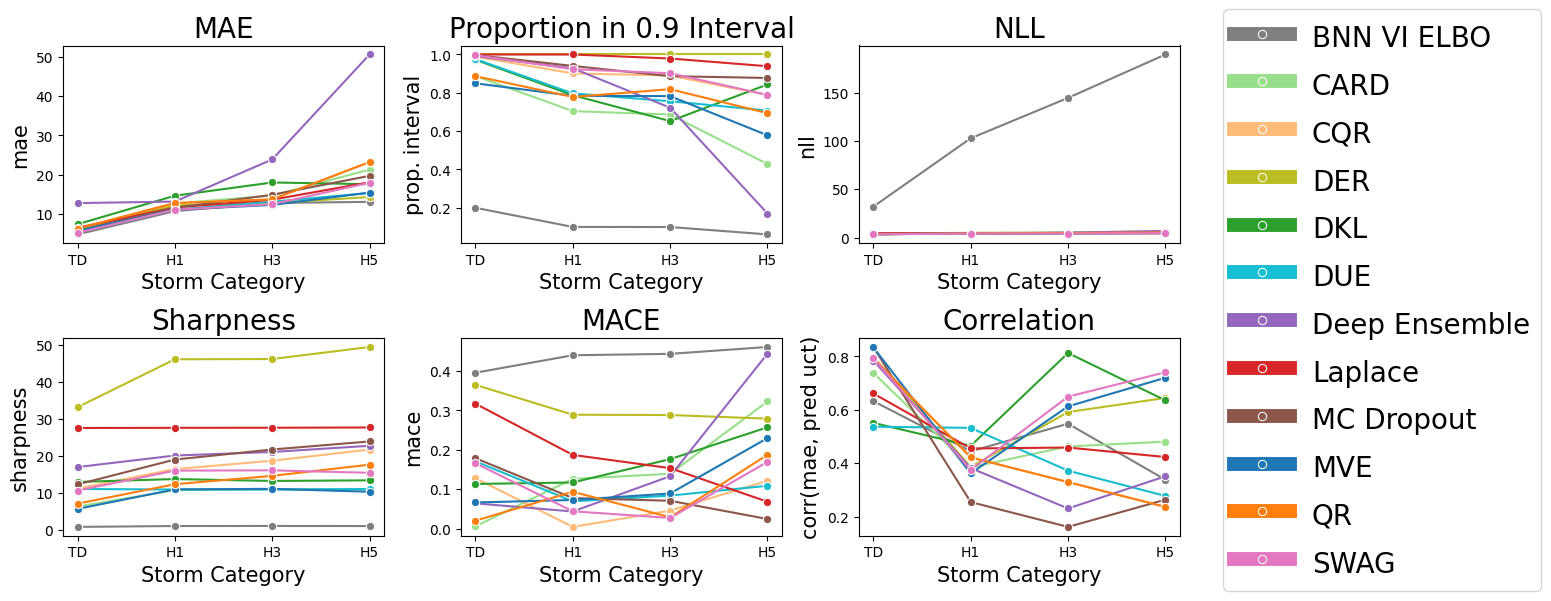

In [31]:
def plot_metrics_by_category(category_df, split_type):
    plot_cat_df = category_df[category_df["split"] == f"preds_{split_type}"]

    # plot per category
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    # Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
    metrics = [
        "mae",
        "proportion_in_0.9_interval",
        "nll",
        "sharpness",
        "mace",
        "correlation",
    ]

    plot_cat_df["storm_category"] = pd.Categorical(
        plot_cat_df["storm_category"], categories=STORM_DISPLAY_ORDER, ordered=True
    )

    plot_cat_df = plot_cat_df[plot_cat_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_cat_df["storm_category"] = plot_cat_df[
        "storm_category"
    ].cat.remove_unused_categories()

    # Loop through the subplots
    for i, metric in enumerate(metrics):
        row = i // 3
        col = i % 3

        # Create the sns plot
        sns.lineplot(
            x="storm_category",
            y=metric,
            hue="uqmethod",
            data=plot_cat_df,
            ax=axes[row, col],
            marker="o",
            palette=color_palette,
        )

        # Add title and increase the size
        axes[row, col].set_title(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)

        # Increase the size of the x and y labels
        axes[row, col].set_xlabel("Storm Category", fontsize=15)
        print(metric)
        if "proportion" in metric:
            axes[row, col].set_ylabel("prop. interval", fontsize=15)
        elif metric == "correlation":
            axes[row, col].set_ylabel("corr(mae, pred uct)", fontsize=15)
        else:
            print(metric)
            axes[row, col].set_ylabel(metric, fontsize=15)

        # Increase the size of the x and y ticks
        axes[row, col].tick_params(axis="both", which="major", labelsize=10)

    # set the linewidths to the copies
    handles, labels = axes[0, 0].get_legend_handles_labels()
    [ha.set_linewidth(10) for ha in handles]

    # Replace the labels using the VAR_TO_PLOT_LABEL dictionary
    labels = [
        VAR_TO_PLOT_LABEL[label] if label in VAR_TO_PLOT_LABEL else label
        for label in labels
    ]

    # Increase the size of the legend labels
    fig.legend(
        handles,
        labels,
        loc="center right",
        bbox_to_anchor=(1.3, 0.5),
        fontsize=20,
        handleheight=1.5,
    )

    # Remove individual legends
    for ax in axes.flat:
        ax.get_legend().remove()

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


# Call the function with 'train' or 'val' as the argument
plot_metrics_by_category(category_df, DS_SPLIT)

In [32]:
correlations_df = (
    category_df.groupby(["uqmethod", "storm_category"])
    .apply(lambda x: x["mae"].corr(x["sharpness"]))
    .reset_index()
)
correlations_df.columns = ["uqmethod", "storm_category", "calibration"]

category_df = category_df.merge(
    correlations_df, on=["uqmethod", "storm_category"], how="left"
)
category_df

/tmp/ipykernel_10930/1138749402.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_df.groupby(["uqmethod", "storm_category"])
/tmp/ipykernel_10930/1138749402.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["mae"].corr(x["sharpness"]))


,index,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,mace,crps,rmse,split,proportion_in_0.9_interval,correlation,calibration
0,0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TD,41.971434,4.729254,31.977914,0.804438,0.395328,4.324714,6.478536,preds_test,0.200060,0.632421,0.975782
1,1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TS,69.903597,6.589160,45.774453,0.942276,0.419226,6.102650,8.360837,preds_test,0.147412,0.537831,0.949967
2,2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,179.695643,10.667229,102.663948,1.043229,0.439592,10.115978,13.405060,preds_test,0.100221,0.444671,0.753654
3,3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,178.953142,10.661241,86.706904,1.089422,0.436978,10.084369,13.377337,preds_test,0.112595,0.548853,0.986900
4,4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,294.984481,12.756169,144.453809,1.058488,0.443202,12.192993,17.175112,preds_test,0.099746,0.547954,0.984330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,3544,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,187.840732,10.788507,4.094619,15.843081,0.051055,7.854763,13.705500,preds_val,0.926606,0.375174,-0.582853
248,3545,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,171.217725,10.388270,4.016960,16.152650,0.069215,7.430214,13.085019,preds_val,0.956120,0.564114,0.324114
249,3546,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,166.825096,10.038276,3.996513,15.471406,0.070319,7.234096,12.916079,preds_val,0.940476,0.649080,0.901267
250,3547,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,347.152914,14.843803,4.364738,15.633477,0.057255,10.505019,18.632040,preds_val,0.849642,0.660919,0.542341


# Tables

## RMSE Overview Table

In [33]:
def generate_latex_table(uq_metric_df, selective_df, split_type):
    category_columns = ["rmse", "crps", "nll", "ma_cal"]
    # table_columns = ["default", "diff"]
    # columns = pd.MultiIndex.from_product(
    #     [["default", "diff"]]
    # )
    combined_df = pd.DataFrame(columns=category_columns)

    table_uq_df = uq_metric_df[uq_metric_df["split"] == f"preds_{split_type}"]
    table_selective_df = selective_df[selective_df["split"] == f"preds_{split_type}"]

    table_uq_df["uqmethod"] = pd.Categorical(
        table_uq_df["uqmethod"], categories=UQ_METHOD_DISPLAY_ORDER, ordered=True
    )

    for metric in category_columns:
        # combined_df[(split_type, metric, "selective")] = table_selective_df[metric]
        combined_df[(metric)] = table_uq_df[metric]
        if "rmse" == metric:
            diff_rmse = table_uq_df[metric] - table_selective_df[metric]
            combined_df.insert(
                combined_df.columns.get_loc(metric) + 1, "diff rmse", diff_rmse
            )
            coverage = table_selective_df["count_total"] / table_uq_df["count_total"]
            combined_df.insert(
                combined_df.columns.get_loc("diff rmse") + 1, "coverage", coverage
            )

    combined_df.insert(0, ("uqmethod"), table_uq_df["uqmethod"])
    combined_df = combined_df.round(2)

    combined_df = combined_df.sort_values("uqmethod")

    # Add a new column for the groups
    combined_df["group"] = combined_df["uqmethod"].apply(
        lambda x: next((k for k, v in UQ_METHOD_GROUPS.items() if x in v), "None")
    )

    # Move the group column to the front
    combined_df = combined_df[
        ["group"] + [col for col in combined_df.columns if col != "group"]
    ]

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    combined_df["uqmethod"] = combined_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    print(combined_df)
    latex_table = as_latex_output(combined_df, category_columns)
    return latex_table


def as_latex_output(combined_df, category_columns):
    """Format latex output"""
    combined_df = combined_df.round(4)
    max_values = combined_df.max()
    min_values = combined_df.min()

    # Replace the group names with the \multirow command
    for group in UQ_METHOD_GROUPS.keys():
        num_rows = len(combined_df[combined_df["group"] == group])
        group_indices = combined_df[combined_df["group"] == group].index
        if len(group_indices) > 0:
            first_index = group_indices[0]
            combined_df.at[first_index, "group"] = (
                r"\multirow{" + str(num_rows) + "}{*}{" + group + "}"
            )
            for index in group_indices[1:]:
                combined_df.at[index, "group"] = ""

    # convert to latex
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.2f")

    # bold face column values
    min_cols = ["rmse", "crps", "nll", "ma_cal"]
    max_cols = ["diff rmse", "coverage"]
    for column in max_values.index:
        if column in max_cols:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        elif column in min_cols:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        else:
            continue

    # Replace the category_columns values using the VAR_TO_PLOT_LABEL dictionary
    for column in category_columns:
        latex_output = latex_output.replace(
            column, VAR_TO_PLOT_LABEL[column] if column in VAR_TO_PLOT_LABEL else column
        )

    # other formatting
    # latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\\multirow", "\\midrule\n\\multirow")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("RMSE", "RMSE $\downarrow$")
    latex_output = latex_output.replace(
        "diff RMSE $\downarrow$", r"RMSE $\Delta$ $\uparrow$"
    )
    latex_output = latex_output.replace("NLL", "NLL $\downarrow$")
    latex_output = latex_output.replace("ma_cal", "MACE $\downarrow$")
    latex_output = latex_output.replace("coverage", r"Coverage $\uparrow$")
    latex_output = latex_output.replace("CRPS", "CRPS $\downarrow$")

    latex_output = latex_output.replace("group", "UQ group")
    latex_output = latex_output.replace("uqmethod", "Method")

    return latex_output


latex_table = generate_latex_table(uq_metric_df, selective_df, DS_SPLIT)
print(latex_table)

            group       uqmethod   rmse  diff rmse  coverage   crps    nll  \
16           None  Deterministic  10.50       0.00      1.00    NaN    NaN   
37  Deterministic            MVE   9.95       2.10      0.62   5.31   3.64   
34  Deterministic            DER  10.14        NaN      0.00  10.07   4.60   
7        Quantile             QR  10.95       3.28      0.44   5.82   3.73   
19       Quantile            CQR  10.95       6.18      0.08   5.98   3.79   
10       Ensemble  Deep Ensemble  16.19        NaN      0.00   8.83   4.15   
31       Bayesian     MC Dropout  10.23       6.12      0.00   5.78   3.81   
22       Bayesian           SWAG   9.78       5.42      0.11   5.40   3.71   
25       Bayesian        Laplace  10.53        NaN      0.00   7.96   4.31   
4        Bayesian    BNN VI ELBO   9.27       0.00      1.00   6.28  52.60   
1        Bayesian            DKL  12.59        NaN      0.00   6.84   3.95   
13       Bayesian            DUE   9.95        NaN      0.00   5

/tmp/ipykernel_10930/919811205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_uq_df["uqmethod"] = pd.Categorical(


In [34]:
#latex table for ICLR selective prediction improvement
print(latex_table)

\begin{tabular}{llrrrrrr}
\toprule
UQ group & Method & RMSE $\downarrow$ & RMSE $\Delta$ $\uparrow$ & Coverage $\uparrow$ & CRPS $\downarrow$ & NLL $\downarrow$ & MACE $\downarrow$ \\
\midrule
None & Deterministic & 10.50 & 0.00 & \textbf{1.0}0 & NaN & NaN & NaN \\
\midrule
\multirow{2}{*}{Deterministic} & MVE & 9.95 & 2.10 & 0.62 & \textbf{5.31} & \textbf{3.64} & 0.04 \\
 & DER & 10.14 & NaN & 0.00 & 10.07 & 4.60 & 0.35 \\
\midrule
\multirow{2}{*}{Quantile} & QR & 10.95 & 3.28 & 0.44 & 5.82 & 3.73 & \textbf{0.01} \\
 & CQR & 10.95 & \textbf{6.18} & 0.08 & 5.98 & 3.79 & 0.10 \\
\midrule
\multirow{1}{*}{Ensemble} & Deep Ensemble & 16.19 & NaN & 0.00 & 8.83 & 4.15 & 0.05 \\
\midrule
\multirow{6}{*}{Bayesian} & MC Dropout & 10.23 & 6.12 & 0.00 & 5.78 & 3.81 & 0.16 \\
 & SWAG & 9.78 & 5.42 & 0.11 & 5.40 & 3.71 & 0.13 \\
 & Laplace & 10.53 & NaN & 0.00 & 7.96 & 4.31 & 0.28 \\
 & BNN VI ELBO & \textbf{9.27} & 0.00 & \textbf{1.0}0 & 6.28 & 52.60 & 0.41 \\
 & DKL & 12.59 & NaN & 0.00 & 6.84 & 

In [35]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,3.949773,6.848777,3.457718,35.533872,0.064776,0.056251,0.056815,13.124807,9.342685,12.698880,...,/p/project/hai_uqmethodbox/experiment_output/m...,3217,4521,1090,433,588,419,68,10336,DKLRegression
1,3.948189,6.840202,3.453518,35.380967,0.065011,0.055761,0.056318,13.164921,9.340257,12.586209,...,/p/project/hai_uqmethodbox/experiment_output/m...,16670,18662,4071,1572,1574,939,147,43635,DKLRegression
2,3.861324,6.293967,3.177965,32.147211,0.082573,0.072472,0.073201,13.120582,8.623980,11.356123,...,/p/project/hai_uqmethodbox/experiment_output/m...,18029,24483,6145,2662,2660,2041,328,56348,DKLRegression
3,58.101242,6.685429,3.352030,61.873531,0.479794,0.416516,0.420723,0.950247,7.160022,9.891810,...,/p/project/hai_uqmethodbox/experiment_output/m...,3217,4521,1090,433,588,419,68,10336,BNN_VI_ELBO_Regression
4,52.603906,6.275765,3.147070,57.680836,0.477091,0.413778,0.417958,0.943718,6.744963,9.274502,...,/p/project/hai_uqmethodbox/experiment_output/m...,16670,18662,4071,1572,1574,939,147,43635,BNN_VI_ELBO_Regression
5,4.356502,1.424309,0.717594,9.593383,0.273263,0.242259,0.244706,0.888683,1.769174,2.404192,...,/p/project/hai_uqmethodbox/experiment_output/m...,18029,24483,6145,2662,2660,2041,328,56348,BNN_VI_ELBO_Regression
6,3.799299,6.286635,3.173897,31.935730,0.011250,0.009324,0.009407,10.764476,8.758051,12.056662,...,/p/project/hai_uqmethodbox/experiment_output/m...,3217,4521,1090,433,588,419,68,10336,QuantileRegression
7,3.727799,5.819242,2.938107,29.226523,0.015484,0.013569,0.013706,10.136679,8.145264,10.954583,...,/p/project/hai_uqmethodbox/experiment_output/m...,16670,18662,4071,1572,1574,939,147,43635,QuantileRegression
8,3.676418,5.581838,2.818391,27.804536,0.018004,0.016157,0.016316,10.689566,7.831585,10.398647,...,/p/project/hai_uqmethodbox/experiment_output/m...,18029,24483,6145,2662,2660,2041,328,56348,QuantileRegression
9,3.882303,6.062070,3.060786,32.794905,0.204953,0.183441,0.185294,16.725278,7.621405,10.694745,...,/p/project/hai_uqmethodbox/experiment_output/m...,3221,4517,1089,433,582,426,67,10335,DeepEnsembleRegression


## Metric Computation per Category

In [36]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product(
    [splits, category_columns, ["default", "selective", "diff"]]
)
combined_df = pd.DataFrame(columns=columns)

## Error Analysis per Category

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/min

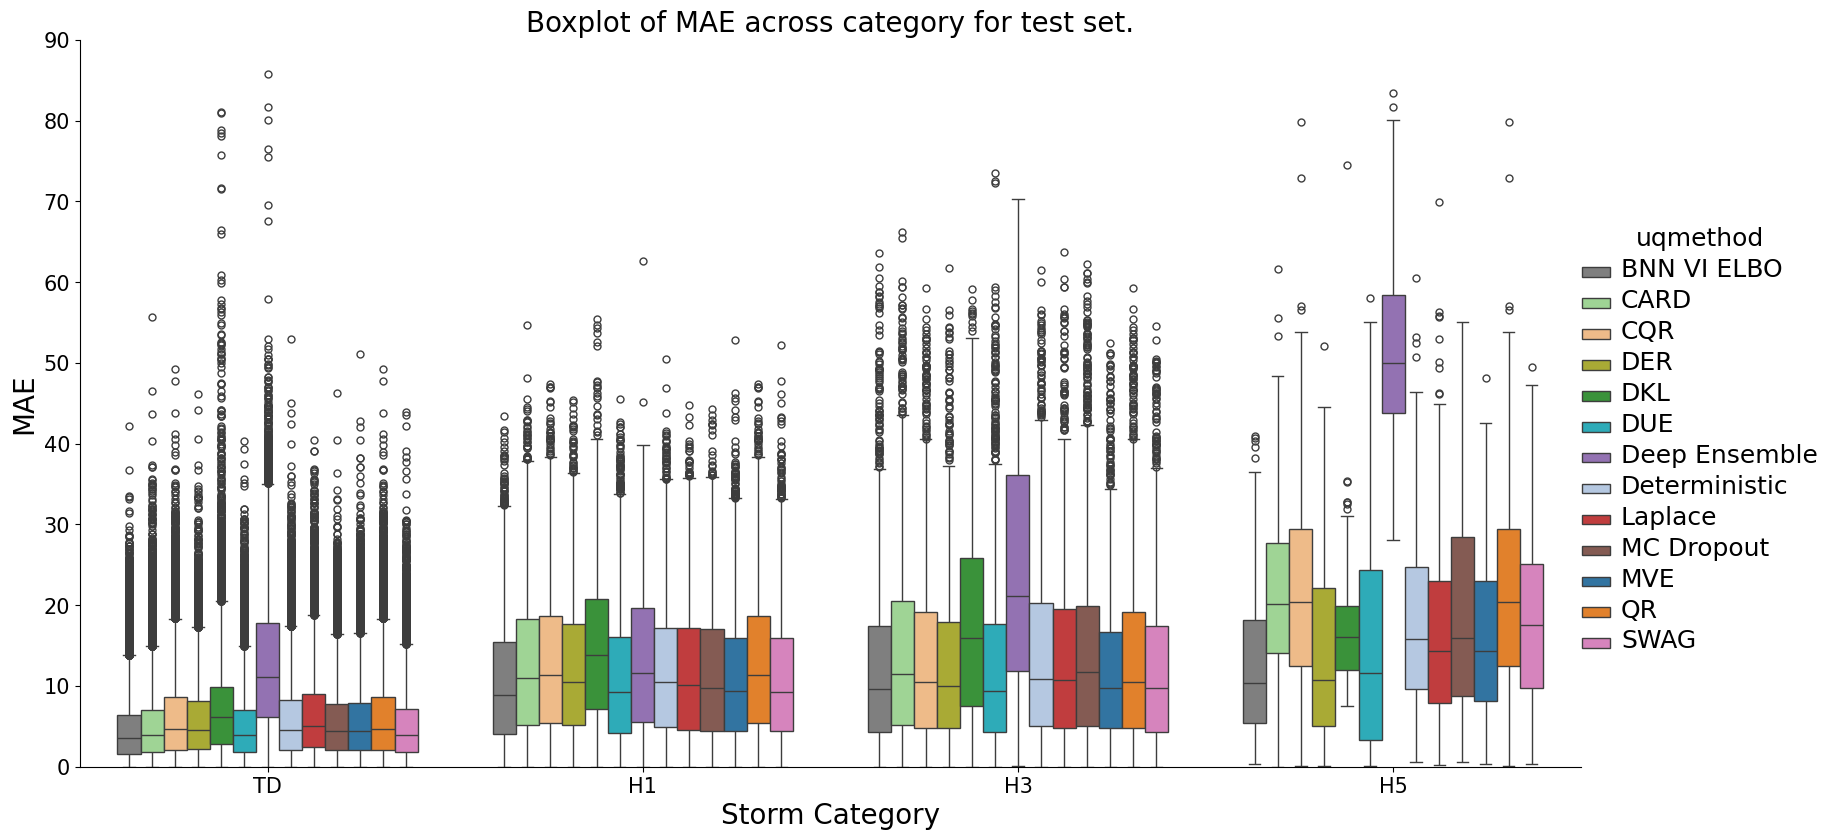

In [37]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(
        lambda x: x.isna().any()
    )
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()

    g = sns.catplot(
        plot_df,
        kind="box",
        x="storm_category",
        y=metric,
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
    )

    ax = g.ax

    # Add horizontal lines behind each x value group
    for i, artist in enumerate(ax.artists):
        if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
            artist.set_edgecolor("black")  # Set the edge color to black

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    #limit outliers on y axis
    ax.set(ylim=(0, 90))

    plt.title(
        f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.",
        fontsize=20,
    )
    plt.ylabel(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with 'val' or 'train' as the split argument and 'mae' or any other metric as the metric argument
plot_boxplot(all_test_pred_df, DS_SPLIT, "mae")

# Selective prediction per Storm Category

In [38]:
from sklearn.metrics import mean_squared_error


def generate_summary_table(all_test_pred_df, split):
    # Compute RMSE for all samples per uqmethod
    rmse_all_samples = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby("uqmethod", observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all_samples.columns = ["uqmethod", "RMSE_All"]

    # Add the "all" category
    rmse_all_samples["storm_category"] = "all"

    # Compute RMSE per method and category
    rmse_all = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all.columns = ["uqmethod", "storm_category", "RMSE_All"]

    # Append the new rows to the RMSE_All DataFrame
    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(["pred_path", "storm_category"], observed=False)
        .apply(
            lambda group: group[
                group["pred_uct"]
                < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]
            ]
        )
        .reset_index(drop=True)
    )

    rmse_all_samples_filtered = (
        df_filtered.groupby("uqmethod", observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all_samples_filtered.columns = ["uqmethod", "RMSE_Uncertainty_Less_Threshold"]

    # Add the "all" category
    rmse_all_samples_filtered["storm_category"] = "all"

    # Compute RMSE per method and category for the filtered DataFrame
    rmse_filtered = (
        df_filtered.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_filtered.columns = [
        "uqmethod",
        "storm_category",
        "RMSE_Uncertainty_Less_Threshold",
    ]

    # Append the new rows to the RMSE_Uncertainty_Less_Threshold DataFrame
    rmse_filtered = pd.concat(
        [rmse_filtered, rmse_all_samples_filtered], ignore_index=True
    )

    # Merge the two DataFrames on method and category
    summary_table = pd.merge(
        rmse_all, rmse_filtered, on=["uqmethod", "storm_category"], how="left"
    )

    # If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
    summary_table.fillna({"RMSE_Uncertainty_Less_Threshold": np.nan}, inplace=True)

    summary_table["pct_change"] = (
        (summary_table["RMSE_Uncertainty_Less_Threshold"] - summary_table["RMSE_All"])
        / summary_table["RMSE_All"]
    ) * 100
    summary_table["abs_change"] = np.abs(
        summary_table["RMSE_Uncertainty_Less_Threshold"] - summary_table["RMSE_All"]
    )
    summary_table["abs_change"] = summary_table["abs_change"].fillna(0)

    return summary_table


# Call the function with 'val' or 'train' as the argument
summary_table = generate_summary_table(all_test_pred_df, DS_SPLIT)
print(summary_table)

/tmp/ipykernel_10930/2458153804.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
/tmp/ipykernel_10930/2458153804.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))


                   uqmethod storm_category   RMSE_All  \
0    BNN_VI_ELBO_Regression             TD   6.478536   
1    BNN_VI_ELBO_Regression             TS   8.360837   
2    BNN_VI_ELBO_Regression             H1  13.405060   
3    BNN_VI_ELBO_Regression             H2  13.377337   
4    BNN_VI_ELBO_Regression             H3  17.175112   
..                      ...            ...        ...   
99        LaplaceRegression            all  10.527570   
100     MCDropoutRegression            all  10.229750   
101           MVERegression            all   9.947039   
102      QuantileRegression            all  10.954583   
103          SWAGRegression            all   9.779521   

     RMSE_Uncertainty_Less_Threshold  pct_change  abs_change  
0                           4.778926  -26.234484    1.699611  
1                           6.026457  -27.920412    2.334380  
2                           9.332980  -30.377188    4.072080  
3                           9.096698  -31.999188    4.280639  


/tmp/ipykernel_10930/2458153804.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_10930/2458153804.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
/tmp/ipykernel_10930/2458153804.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future v

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

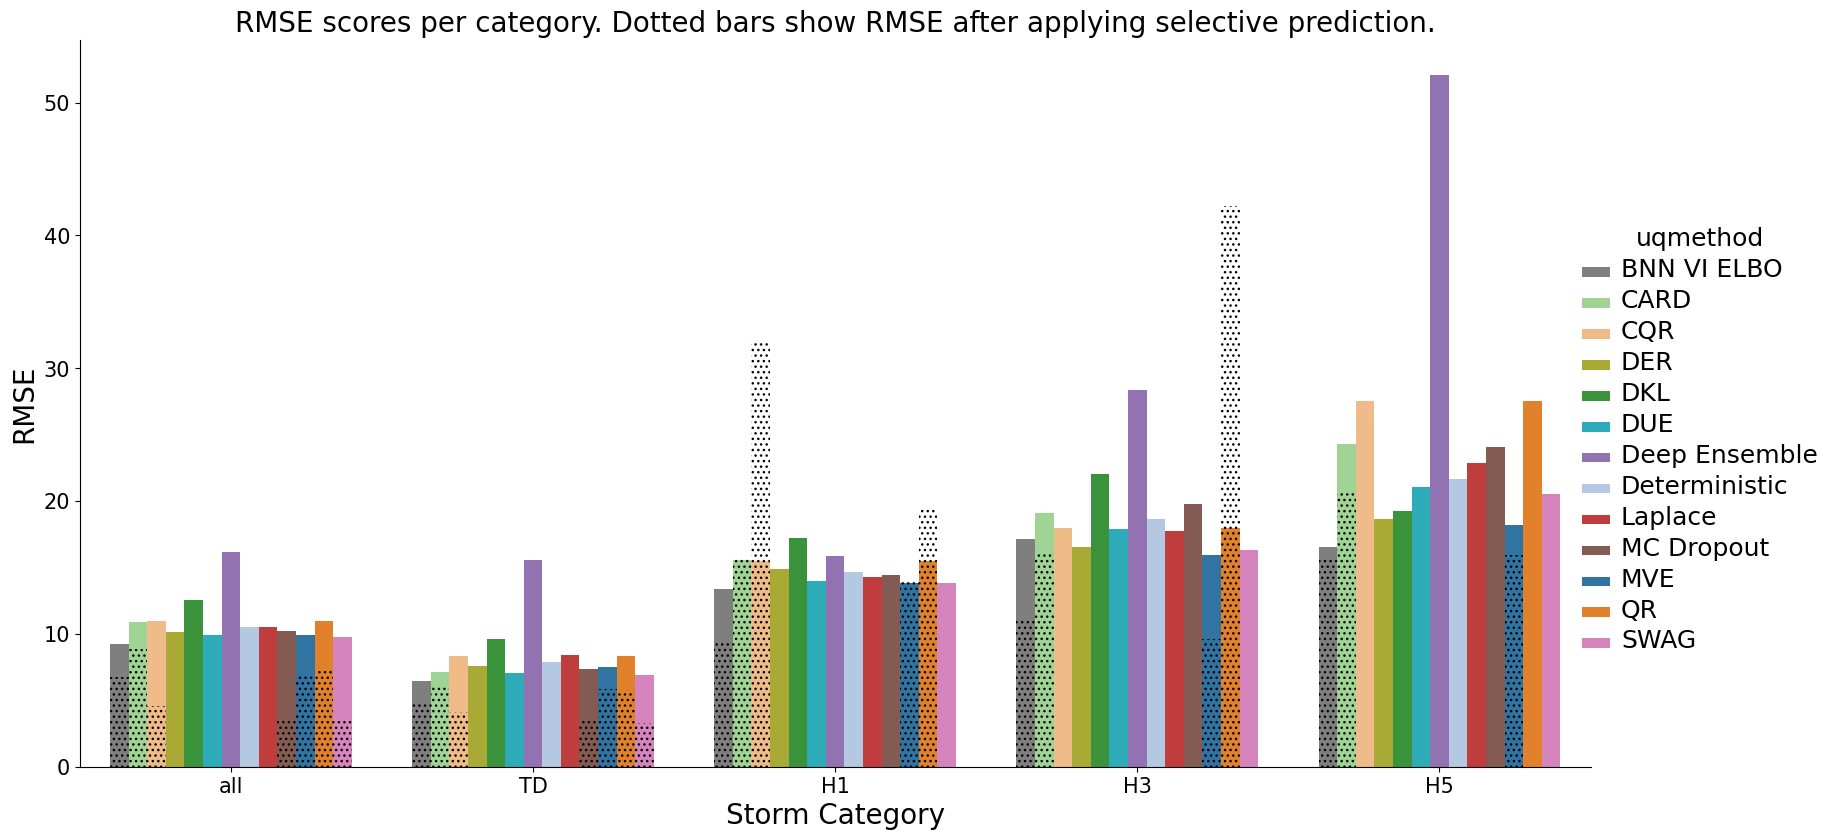

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_bar(summary_table):
    # Convert the storm_category column to 'category' dtype
    summary_table["storm_category"] = summary_table["storm_category"].astype("category")

    # Now you can use the cat accessor
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()

    hue_order = summary_table["uqmethod"].unique().tolist()

    # remove categories with no predictions
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()

    summary_table = summary_table[
        summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)
    ]

    # Use the order parameter in the catplot function
    g = sns.catplot(
        data=summary_table,
        kind="bar",
        x="storm_category",
        y="RMSE_All",
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax = g.ax

    sns.barplot(
        data=summary_table,
        x="storm_category",
        y="RMSE_Uncertainty_Less_Threshold",
        hue="uqmethod",
        alpha=0.0,
        ax=ax,
        hatch="...",
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax.get_legend().remove()

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )
    plt.title(
        "RMSE scores per category. Dotted bars show RMSE after applying selective prediction.",
        fontsize=20,
    )
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with the summary table as the argument
plot_bar(summary_table)

In [40]:
def compute_summary(all_test_pred_df, split):
    rmse_all_samples = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby("uqmethod", observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_all_samples.columns = ["uqmethod", "SHARP_All"]

    # Add the "all" category
    rmse_all_samples["storm_category"] = "all"

    # Compute RMSE per method and category
    rmse_all = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_all.columns = ["uqmethod", "storm_category", "SHARP_All"]

    # Append the new rows to the RMSE_All DataFrame
    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(["pred_path", "storm_category"], observed=False)
        .apply(
            lambda group: group[
                group["pred_uct"]
                < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]
            ]
        )
        .reset_index(drop=True)
    )

    # Compute RMSE per method and category over filtered predictions
    rmse_filtered = (
        df_filtered.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_filtered.columns = [
        "uqmethod",
        "storm_category",
        "SHARP_Uncertainty_Less_Threshold",
    ]

    # Merge the two DataFrames on method and category
    summary_table = pd.merge(
        rmse_all, rmse_filtered, on=["uqmethod", "storm_category"], how="left"
    )

    # If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
    summary_table.fillna({"SHARP_Uncertainty_Less_Threshold": np.nan}, inplace=True)

    summary_table["pct_change"] = (
        (summary_table["SHARP_Uncertainty_Less_Threshold"] - summary_table["SHARP_All"])
        / summary_table["SHARP_All"]
    ) * 100
    summary_table["abs_change"] = np.abs(
        summary_table["SHARP_Uncertainty_Less_Threshold"] - summary_table["SHARP_All"]
    )
    summary_table["abs_change"] = summary_table["abs_change"].fillna(0)

    return summary_table


# Call the function with all_test_pred_df DataFrame and 'val' or 'train' as the split argument
summary_table = compute_summary(all_test_pred_df, DS_SPLIT)

/tmp/ipykernel_10930/3457675125.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(x["pred_uct"]))
/tmp/ipykernel_10930/3457675125.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(x["pred_uct"]))
/tmp/ipykernel_10930/3457675125.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futur

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

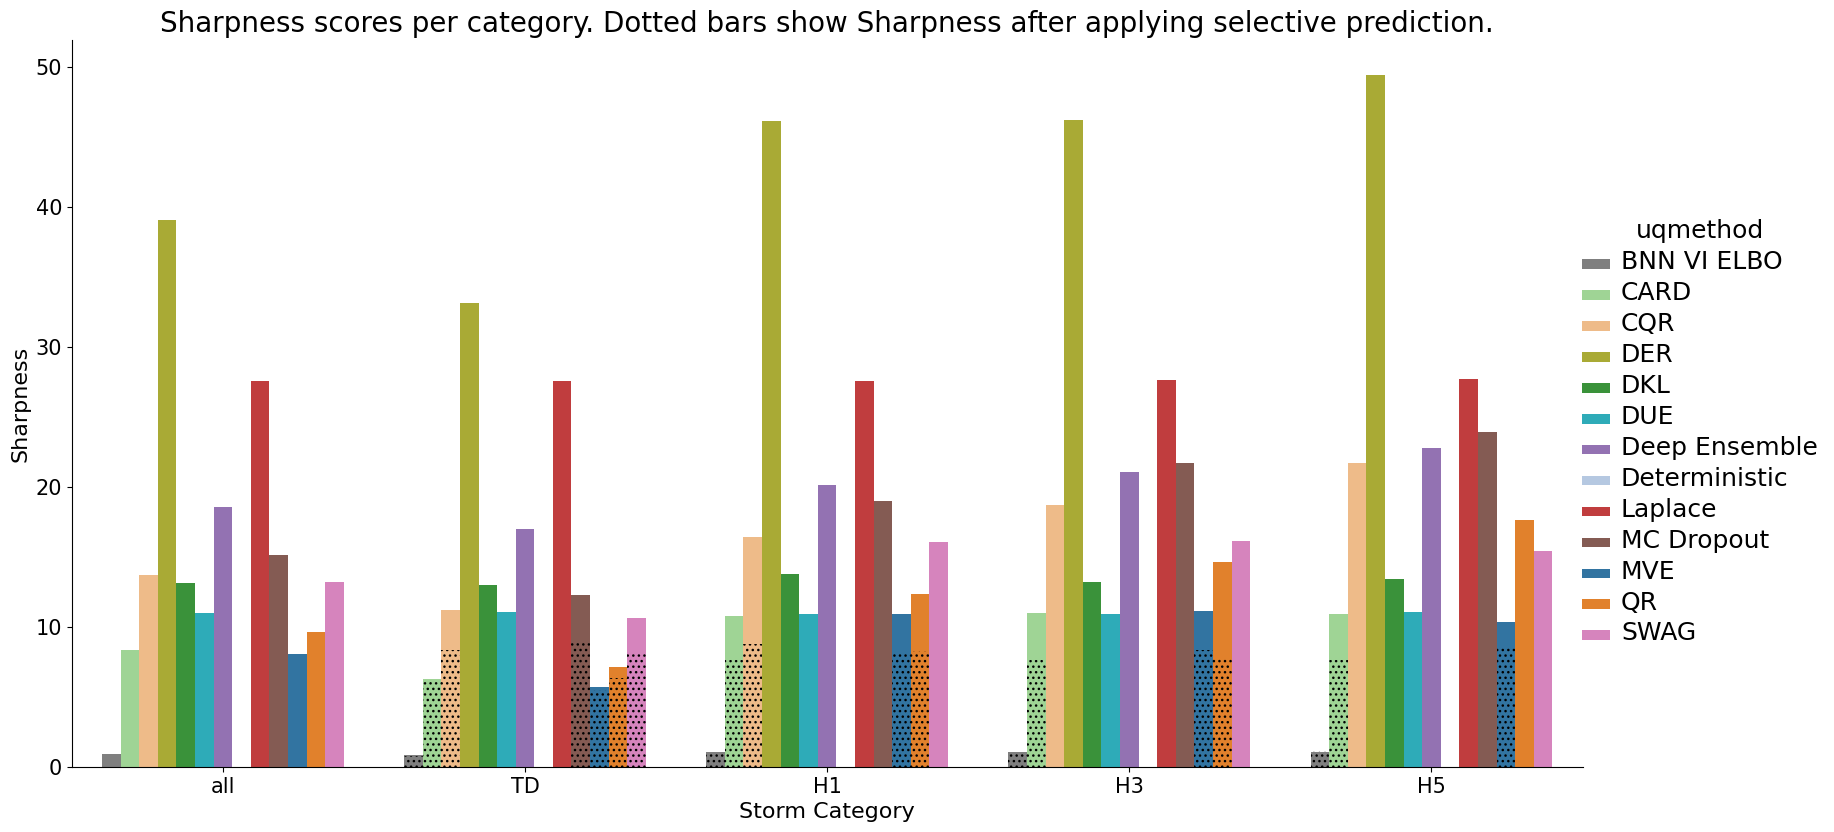

In [41]:
def plot_sharpness(summary_table):
    summary_table["storm_category"] = summary_table["storm_category"].astype("category")
    hue_order = (
        summary_table[summary_table["uqmethod"] != "DERModel"]["uqmethod"]
        .unique()
        .tolist()
    )
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()
    summary_table = summary_table[
        summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)
    ]

    g = sns.catplot(
        data=summary_table[summary_table["uqmethod"] != "DERModel"],
        kind="bar",
        x="storm_category",
        y="SHARP_All",
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax = g.ax

    sns.barplot(
        data=summary_table,
        x="storm_category",
        y="SHARP_Uncertainty_Less_Threshold",
        hue="uqmethod",
        alpha=0.0,
        ax=ax,
        hatch="...",
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax.get_legend().remove()

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.title(
        "Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.",
        fontsize=20,
    )
    plt.ylabel("Sharpness", fontsize=16)
    plt.xlabel("Storm Category", fontsize=16)
    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with the summary table as the argument
plot_sharpness(summary_table)

# Calibration

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/min

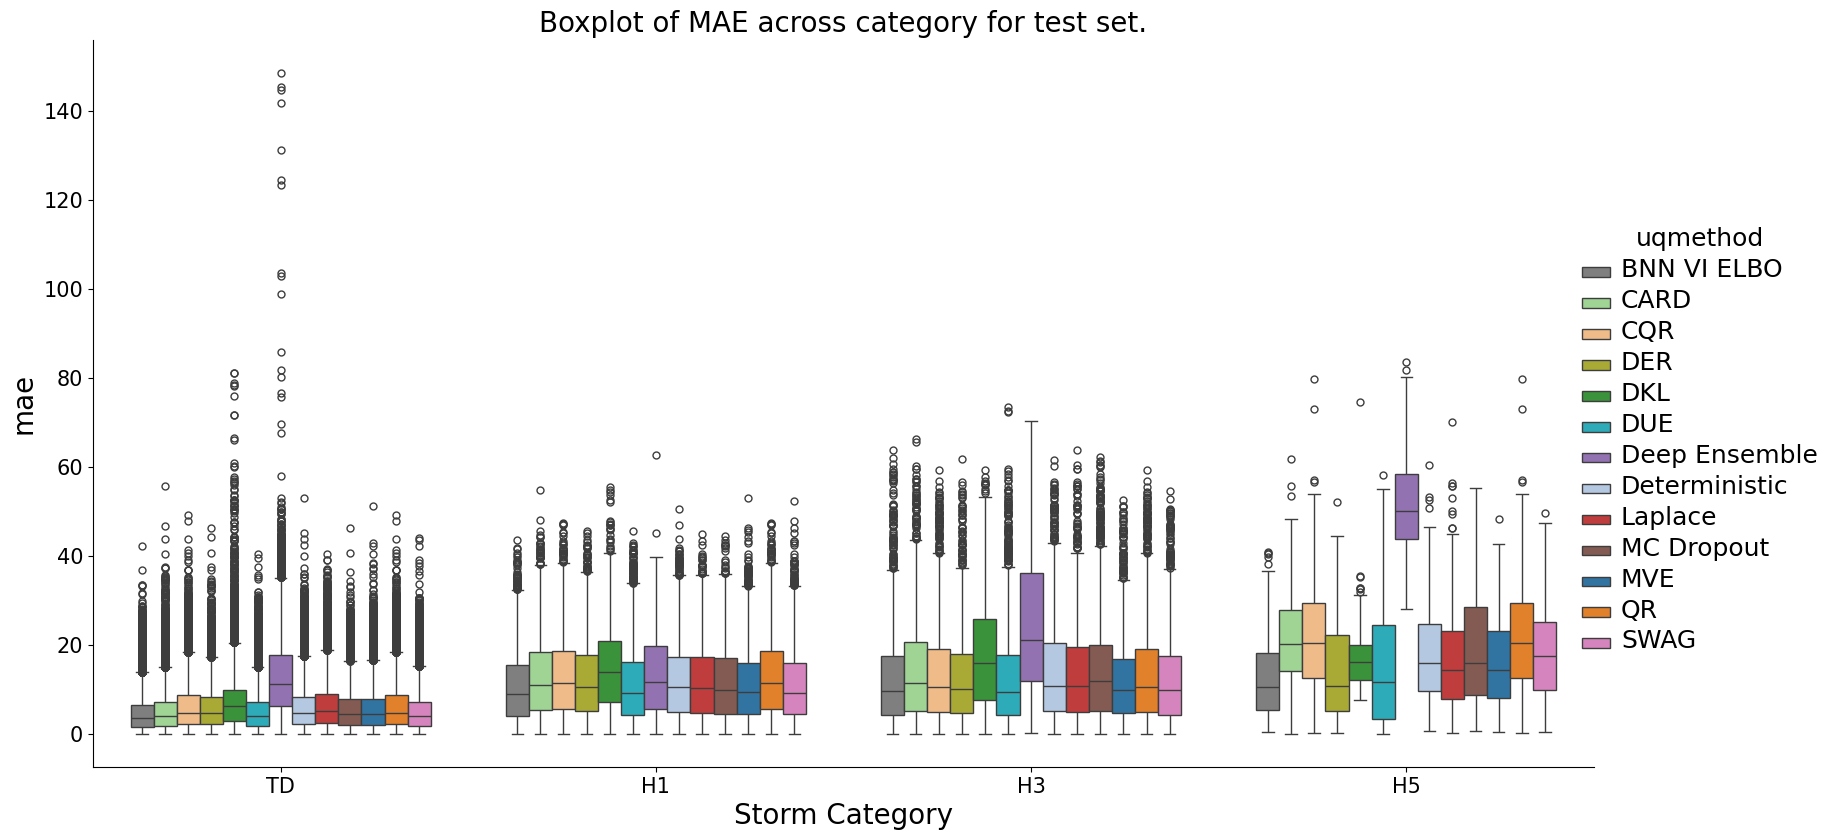

In [42]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(
        lambda x: x.isna().any()
    )
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()
    g = sns.catplot(
        plot_df,
        kind="box",
        x="storm_category",
        y=metric,
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
    )

    ax = g.ax

    # Add horizontal lines behind each x value group
    for i, artist in enumerate(ax.artists):
        if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
            artist.set_edgecolor("black")  # Set the edge color to black

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.title(
        f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.",
        fontsize=20,
    )
    plt.ylabel(f"{metric}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)
    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with 'val' or 'train' as the split argument and 'mae' or any other metric as the metric argument
plot_boxplot(all_test_pred_df, DS_SPLIT, "mae")

In [43]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions,
        obs_proportions,
        label=curve_label.replace("Model", ""),
        c=color_palette[curve_label],
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )

    # Annotate plot with the miscalibration area
    # ax.text(
    #     x=0.95,
    #     y=0.05,
    #     s="Miscalibration area = %.2f" % miscalibration_area,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     fontsize="small",
    # )

    return ax

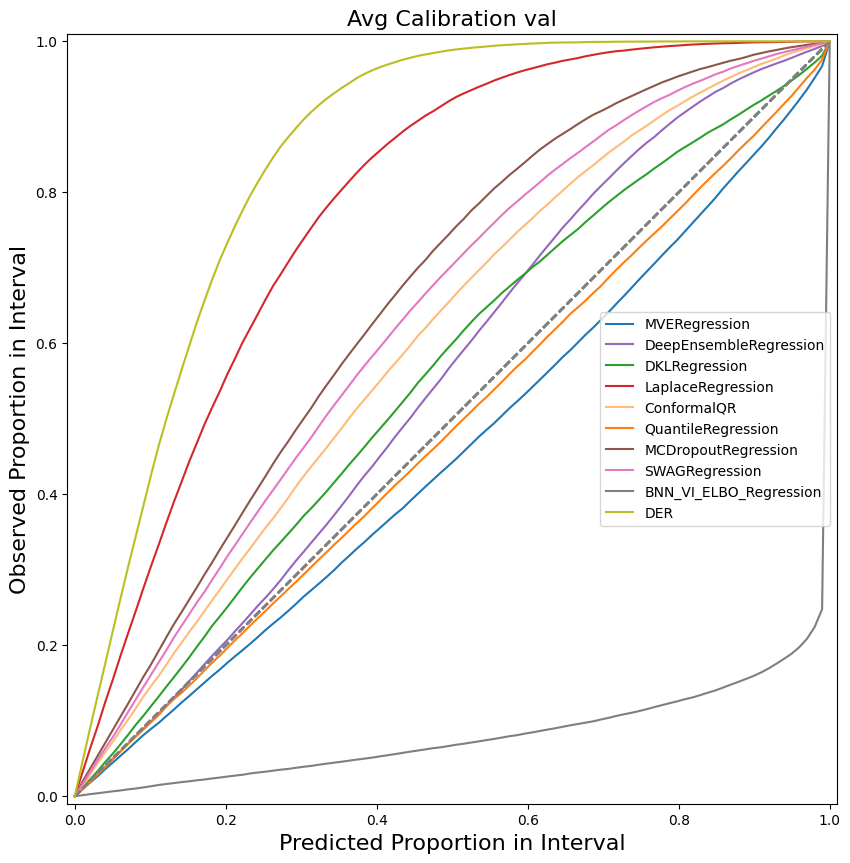

In [44]:
uq_methods_to_show = [
    "MVERegression",
    "DeepEnsembleRegression",
    "DKLRegression",
    "LaplaceRegression",
    "ConformalQR",
    "QuantileRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "BNN_VI_ELBO_Regression",
    "DER",
]

split = "val"

fig, axs = plt.subplots(1, figsize=(10, 10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    plot_df = plot_df[plot_df["split"] == f"preds_{DS_SPLIT}"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split,
            )
plt.legend()

# Correlation between Predictive Uncertainty and Errors

/tmp/ipykernel_10930/1343801875.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_10930/1343801875.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


                   uqmethod storm_category   level_2       mae  pred_uct
0    BNN_VI_ELBO_Regression             TD       mae  1.000000  0.264842
1    BNN_VI_ELBO_Regression             TD  pred_uct  0.264842  1.000000
2    BNN_VI_ELBO_Regression             TS       mae  1.000000  0.075663
3    BNN_VI_ELBO_Regression             TS  pred_uct  0.075663  1.000000
4    BNN_VI_ELBO_Regression             H1       mae  1.000000 -0.110658
..                      ...            ...       ...       ...       ...
163          SWAGRegression             H3  pred_uct  0.298160  1.000000
164          SWAGRegression             H4       mae  1.000000  0.321837
165          SWAGRegression             H4  pred_uct  0.321837  1.000000
166          SWAGRegression             H5       mae  1.000000  0.480818
167          SWAGRegression             H5  pred_uct  0.480818  1.000000

[168 rows x 5 columns]
                   uqmethod storm_category   level_2       mae  pred_uct  \
0    BNN_VI_ELBO_Regress

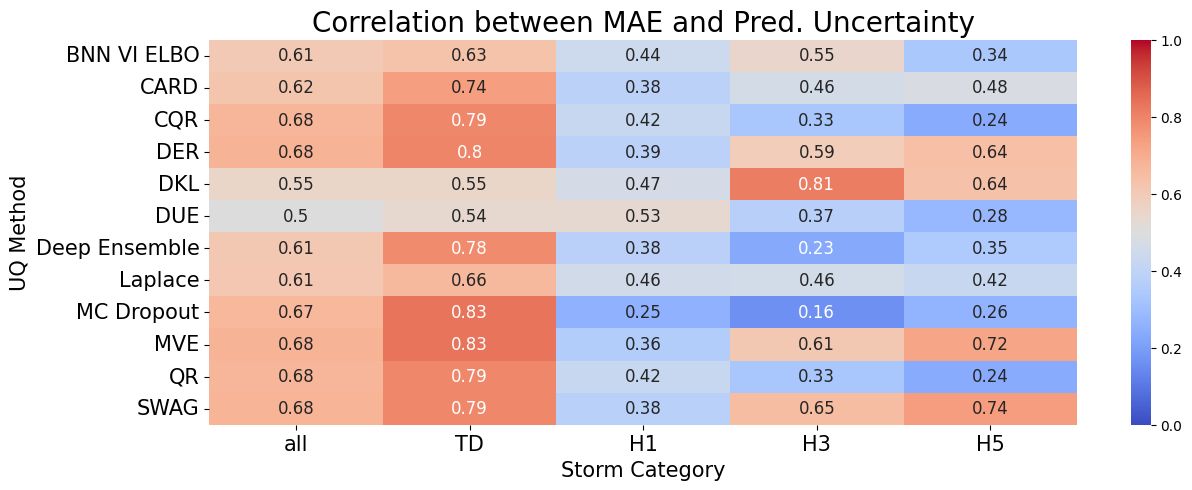

In [45]:
def plot_correlation_heatmap(all_test_pred_df, split, corr_one, corr_two):
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{split}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]

    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    print(corr_df)
    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df["storm_category"] = "all"

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    print(corr_df)
    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )
    print(pivot_table)

    pivot_table = pivot_table.reindex(STORM_DISPLAY_ORDER, axis=1)

    # Create a heatmap from the pivot table
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
        annot_kws={"fontsize": 12},
    )

    # Set the title and increase the size of the labels
    plt.title(
        f"Correlation between {VAR_TO_PLOT_LABEL[corr_one]} and {VAR_TO_PLOT_LABEL[corr_two]}",
        fontsize=20,
    )
    plt.xlabel("Storm Category", fontsize=15)
    plt.ylabel("UQ Method", fontsize=15)

    # Increase the size of the tick labels
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Replace the y-tick labels using the VAR_TO_PLOT_LABEL dictionary
    yticklabels = [
        (
            VAR_TO_PLOT_LABEL[label.get_text()]
            if label.get_text() in VAR_TO_PLOT_LABEL
            else label.get_text()
        )
        for label in plt.gca().get_yticklabels()
    ]
    plt.gca().set_yticklabels(yticklabels)

    # Show the plot
    plt.show()


# Call the function with the all_test_pred_df DataFrame, 'val' as the split argument, and 'mae' and 'pred_uct' as the correlation arguments
plot_correlation_heatmap(all_test_pred_df, DS_SPLIT, "mae", "pred_uct")

              pred   pred_uct  epistemic_uct      target           uqmethod  \
884527  120.444205  27.606234       0.112764  137.000000  LaplaceRegression   
884528  121.650196  27.644749       0.125218  138.000002  LaplaceRegression   
884529  122.460068  27.653549       0.127896  138.000002  LaplaceRegression   
884530  119.261285  27.638554       0.123300  138.999999  LaplaceRegression   
884531  119.545224  27.623099       0.118377  140.000001  LaplaceRegression   
...            ...        ...            ...         ...                ...   
925026  122.368787  27.604626       0.112216  140.000001  LaplaceRegression   
925027  126.619305  27.611622       0.114588  140.000001  LaplaceRegression   
925028  125.024879  27.639430       0.123572  140.000001  LaplaceRegression   
925029  121.738037  27.654693       0.128241  138.000002  LaplaceRegression   
925030  124.848052  27.588313       0.106481  137.000000  LaplaceRegression   

             split                                 

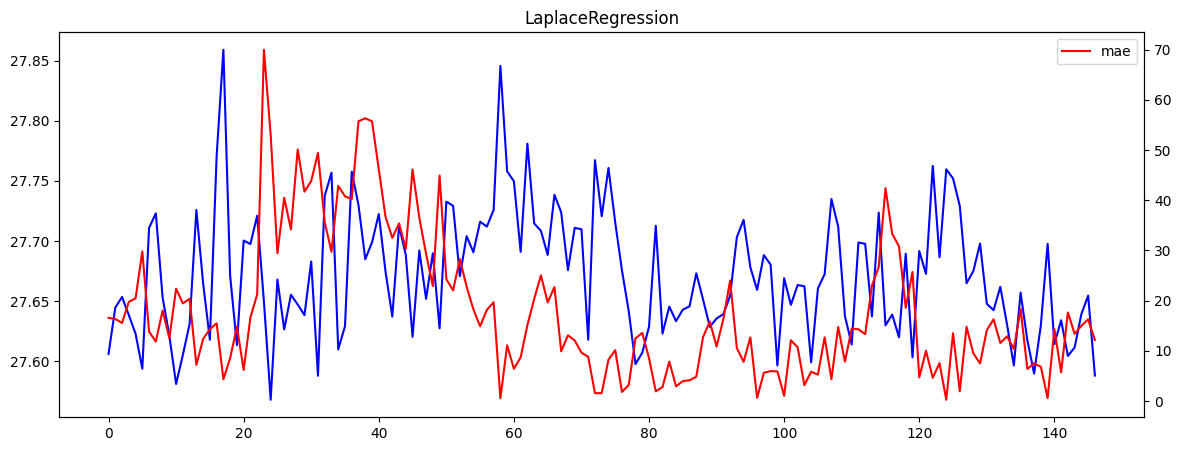

In [46]:
method = "LaplaceRegression"

test_df_split = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"]
test_df_split = test_df_split[test_df_split["storm_category"] == "H5"]
test_df_split = test_df_split[test_df_split["uqmethod"] == method]
print(test_df_split)

# test_df_split[test_df_split["uqmethod"] == "SWAGRegression"]["pred_uct"]
left = "pred_uct"
right = "mae"
plt.plot(range(len(test_df_split)), test_df_split[left], color="blue", label=left)
plt.twinx()
plt.plot(range(len(test_df_split)), test_df_split[right], color="red", label=right)
plt.title(method)
plt.legend()

In [47]:
DS_SPLIT

'test'

# Track Prediction Visualization

In [48]:
# get a config from the overview_df
config = OmegaConf.load(os.path.join(os.path.dirname(dir_paths[0]), "config.yaml"))
datamodule = instantiate(config.datamodule)
datamodule.setup(stage="fit")
datamodule.setup(stage="test")

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [49]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))

69267
56348
10335
2584
43635


(None, None, None, None, None)

In [50]:
test_df = test_ds.sequence_df
test_df["storm_category"] = pd.cut(
    test_df["wind_speed"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
)
test_df["storm_category"].value_counts()

storm_category
TS    18851
TD    16277
H1     4184
H2     1663
H3     1574
H4      939
H5      147
Name: count, dtype: int64

In [51]:
split_df = all_test_pred_df[
    all_test_pred_df["split"] == f"preds_{str('test')}"
].reset_index()
grouped = split_df.groupby(["uqmethod", "split"])

# Get the size of each group
group_sizes = grouped.size()

# Print the sizes
print(group_sizes)

uqmethod                 split     
BNN_VI_ELBO_Regression   preds_test    43635
CARDRegression           preds_test    43635
ConformalQR              preds_test    43635
DER                      preds_test    43635
DKLRegression            preds_test    43635
DUERegression            preds_test    43635
DeepEnsembleRegression   preds_test    43635
DeterministicRegression  preds_test    43635
LaplaceRegression        preds_test    43635
MCDropoutRegression      preds_test    43635
MVERegression            preds_test    43635
QuantileRegression       preds_test    43635
SWAGRegression           preds_test    43635
dtype: int64


In [52]:
dataset.sequence_df

,storm_id,subsequences,wind_speed,wind_bins
0,abs,"[0, 1, 2]",45,9.0
1,abs,"[1, 2, 3]",52,10.0
2,abs,"[2, 3, 4]",53,10.0
3,abs,"[3, 4, 5]",62,12.0
4,abs,"[4, 5, 6]",63,12.0
...,...,...,...,...
69264,zzp,"[219, 220, 221]",42,8.0
69265,zzp,"[220, 221, 222]",40,8.0
69266,zzp,"[221, 222, 223]",37,7.0
69267,zzp,"[222, 223, 224]",35,7.0


In [53]:
test_ds.sequence_df

,storm_id,subsequences,wind_speed,wind_bins,storm_category
0,acd,"[123, 124, 125]",33,6,TS
1,acd,"[124, 125, 126]",33,6,TS
2,acd,"[125, 126, 127]",32,6,TD
3,acd,"[126, 127, 128]",32,6,TD
4,acd,"[127, 128, 129]",31,6,TD
...,...,...,...,...,...
43630,zza,"[172, 173, 174]",20,4,TD
43631,zza,"[173, 174, 175]",20,4,TD
43632,zza,"[174, 175, 176]",20,4,TD
43633,zza,"[175, 176, 177]",20,4,TD


In [54]:
test_ds.sequence_df[test_ds.sequence_df["storm_id"] == "zoi"]

,storm_id,subsequences,wind_speed,wind_bins,storm_category


In [55]:
all_test_pred_df

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,storm_id,relative_time,ocean,...,upper_quant,aleatoric_uct,wind_speed,target_mean,target_std,storm_category,mse,mae,nll,date
0,27.138703,0.951457,0.035508,32.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,307798.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,34.354784,5.861295,19.844060,NaT
1,26.117810,0.866908,0.032353,32.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,309598.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,47.364519,6.882189,32.288208,NaT
2,25.733327,0.769795,0.028729,31.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,313198.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,39.271179,6.266672,33.792818,NaT
3,24.459123,0.861460,0.032150,31.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,314998.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,56.864810,7.540876,39.082540,NaT
4,24.719387,0.956099,0.035682,30.999998,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,316799.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,39.446074,6.280611,22.449910,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434141,62.394465,15.567978,0.030787,71.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.580181,NaN,50.344008,26.795277,H1,74.055234,8.605535,3.816933,NaT
1434142,99.349355,14.018799,0.037920,110.000001,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.521806,NaN,50.344008,26.795277,H3,113.436255,10.650646,3.847940,NaT
1434143,32.555181,11.664079,0.037955,42.999998,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.433646,NaN,50.344008,26.795277,TS,109.094209,10.444817,3.776385,NaT
1434144,42.211941,14.110436,0.032120,33.999999,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.525621,NaN,50.344008,26.795277,TS,67.436004,8.211943,3.735202,NaT


In [56]:
# Get the size of each group
group_sizes = grouped.size()

# Print the sizes
print(group_sizes)

uqmethod                 split     
BNN_VI_ELBO_Regression   preds_test    43635
CARDRegression           preds_test    43635
ConformalQR              preds_test    43635
DER                      preds_test    43635
DKLRegression            preds_test    43635
DUERegression            preds_test    43635
DeepEnsembleRegression   preds_test    43635
DeterministicRegression  preds_test    43635
LaplaceRegression        preds_test    43635
MCDropoutRegression      preds_test    43635
MVERegression            preds_test    43635
QuantileRegression       preds_test    43635
SWAGRegression           preds_test    43635
dtype: int64


In [57]:
all_test_pred_df

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,storm_id,relative_time,ocean,...,upper_quant,aleatoric_uct,wind_speed,target_mean,target_std,storm_category,mse,mae,nll,date
0,27.138703,0.951457,0.035508,32.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,307798.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,34.354784,5.861295,19.844060,NaT
1,26.117810,0.866908,0.032353,32.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,309598.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,47.364519,6.882189,32.288208,NaT
2,25.733327,0.769795,0.028729,31.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,313198.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,39.271179,6.266672,33.792818,NaT
3,24.459123,0.861460,0.032150,31.999999,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,314998.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,56.864810,7.540876,39.082540,NaT
4,24.719387,0.956099,0.035682,30.999998,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,316799.0,1.0,...,NaN,NaN,NaN,50.344008,26.795277,TD,39.446074,6.280611,22.449910,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434141,62.394465,15.567978,0.030787,71.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.580181,NaN,50.344008,26.795277,H1,74.055234,8.605535,3.816933,NaT
1434142,99.349355,14.018799,0.037920,110.000001,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.521806,NaN,50.344008,26.795277,H3,113.436255,10.650646,3.847940,NaT
1434143,32.555181,11.664079,0.037955,42.999998,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.433646,NaN,50.344008,26.795277,TS,109.094209,10.444817,3.776385,NaT
1434144,42.211941,14.110436,0.032120,33.999999,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,0.525621,NaN,50.344008,26.795277,TS,67.436004,8.211943,3.735202,NaT


In [58]:
dataset.aux_df

AttributeError: 'TropicalCycloneSequence' object has no attribute 'aux_df'

In [ ]:
import uncertainty_toolbox.metrics_calibration as uct_cal
import uncertainty_toolbox.metrics_scoring_rule as uct_score

DS_SPLIT = "test"

# compute average error per track, and add a column that denotes the number of samples per storm_id
error_by_storm_id = (
    all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"]
    .groupby(["storm_id"], observed=False)
    .apply(lambda x: np.mean(np.abs(x["pred"].values - x["target"].values)))
    .reset_index()
)
error_by_storm_id.columns = ["storm_id", "error"]
unique_samples_df = all_test_pred_df[
    all_test_pred_df["split"] == f"preds_{DS_SPLIT}"
].drop_duplicates(subset=["storm_id", "relative_time"])

error_by_storm_id["n_samples"] = (
    unique_samples_df.groupby(["storm_id"], observed=False)
    .apply(lambda x: len(x))
    .values
)

# order the tracks
error_by_storm_id.sort_values(by="error", inplace=True)

# now select the top and bottom 5 given that there are between 50 and 100 samples
error_by_storm_id = error_by_storm_id[error_by_storm_id["n_samples"] > 50].reset_index(
    drop=True
)
first_and_last_ten = pd.concat(
    [error_by_storm_id.iloc[:10], error_by_storm_id.iloc[-10:]]
)

# Print the first and last ten rows
# print(first_and_last_ten)
# error_by_storm_id = error_by_storm_id[error_by_storm_id["n_samples"]<100]

bottom_id = error_by_storm_id.iloc[-1]["storm_id"]
top_id = error_by_storm_id.iloc[0]["storm_id"]


# COMBOS To keep track of
# "bib", "test"
# "hhi", "test"
# "fit", "test"

/tmp/ipykernel_30320/433516172.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(np.abs(x["pred"].values - x["target"].values)))


KeyError: Index(['relative_time'], dtype='object')

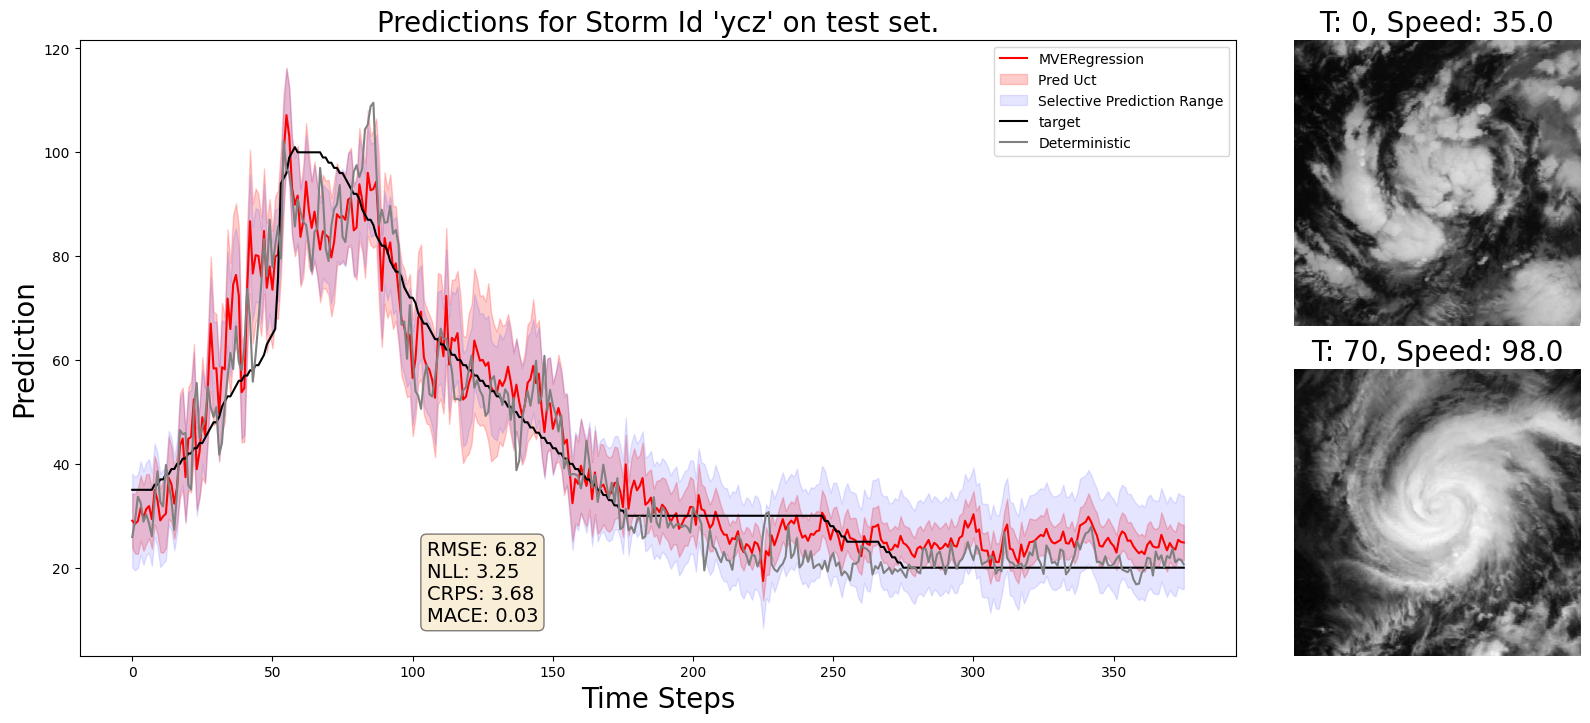

In [ ]:
def plot_track(
    all_test_pred_df,
    storm_id,
    split,
):
    """Generate a plot showing the predictions for a given storm_id over time."""
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]

    plot_df = plot_df[plot_df["storm_id"] == storm_id]
    plot_df = plot_df.sort_values(by="relative_time")

    # a mapping from relative_time to timestep
    unique_times = plot_df["relative_time"].unique()
    time_to_timestep = {time: i for i, time in enumerate(unique_times)}
    plot_df["timestep"] = plot_df["relative_time"].map(time_to_timestep)

    # iterate over the uqmethods
    unique_methods = plot_df["uqmethod"].unique()

    unique_methods = ["MVERegression"]

    ds = {"train": dataset, "val": dataset, "test": test_ds}[split]

    # Create a figure and a grid of subplots
    fig = plt.figure(figsize=(20, 8))
    gs = GridSpec(2, 2, figure=fig, hspace=0.15, wspace=0.01, width_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    # unique_methods = plot_df["uqmethod"].unique()

    for idx, method in enumerate(unique_methods):
        method_df = plot_df[plot_df["uqmethod"] == method]

        # Compute metrics for this storm track
        rmse = np.sqrt(np.mean((method_df["pred"] - method_df["target"]) ** 2))
        nll = uct_score.nll_gaussian(
            method_df["pred"].values,
            method_df["pred_uct"].values,
            method_df["target"].values,
        )
        crps = uct_score.crps_gaussian(
            method_df["pred"].values,
            method_df["pred_uct"].values,
            method_df["target"].values,
        )
        mace = uct_cal.mean_absolute_calibration_error(
            method_df["pred"].values,
            method_df["pred_uct"].values,
            method_df["target"].values,
        )

        metrics_text = (
            f"RMSE: {rmse:.2f}\nNLL: {nll:.2f}\nCRPS: {crps:.2f}\nMACE: {mace:.2f}"
        )

        ax1.plot(
            method_df["timestep"],
            method_df["pred"],
            label=method,
            # c=color_palette[method],
            c="red",
        )
        ax1.fill_between(
            method_df["timestep"],
            method_df["pred"] - method_df["pred_uct"],
            method_df["pred"] + method_df["pred_uct"],
            color="red",
            alpha=0.2,
            label="Pred Uct",
        )

        props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        # Adjust the vertical alignment to 'bottom' and the y position to a smaller value
        ax1.text(
            0.3,
            0.05,
            metrics_text,
            transform=ax1.transAxes,
            fontsize=14,
            verticalalignment="bottom",
            bbox=props,
        )
        # # print(method_df.iloc[0]["pred_path"])
        ax1.fill_between(
            method_df["timestep"],
            method_df["pred"] - SELECTIVE_THRESH,
            method_df["pred"] + SELECTIVE_THRESH,
            color="blue",
            alpha=0.1,
            label="Selective Prediction Range",
        )

    # plot ground truth just from last one since it is the same for all
    ax1.plot(method_df["timestep"], method_df["target"], label="target", c="black")

    # plot the deterministic model prediction
    ax1.plot(
        plot_df[plot_df["uqmethod"] == "DeterministicRegression"]["timestep"],
        plot_df[plot_df["uqmethod"] == "DeterministicRegression"]["pred"],
        label="Deterministic",
        c="gray",
    )

    ax1.legend()

    ax1.set_title(f"Predictions for Storm Id '{storm_id}' on {split} set.", fontsize=20)
    ax1.set_ylabel("Prediction", fontsize=20)
    ax1.set_xlabel("Time Steps", fontsize=20)

    # Display the image from the beginning timestep
    rel_time_index = 0
    first_image_index = int(method_df.iloc[rel_time_index]["index"])
    first_sample = ds[first_image_index]
    first_image = first_sample["input"].permute(1, 2, 0).numpy()[..., 0] / 255
    ax2.imshow(first_image, cmap="gray")
    ax2.set_title(
        f"T: {rel_time_index}, Speed: {first_sample['target'].item()}", fontsize=20
    )
    ax2.axis("off")

    # Display the image from the end timestep
    rel_time_index = 70
    last_image_index = int(method_df.iloc[rel_time_index]["index"])
    last_sample = ds[last_image_index]
    last_image = last_sample["input"].permute(1, 2, 0).numpy()[..., 0] / 255
    ax3.imshow(last_image, cmap="gray")
    ax3.set_title(
        f"T: {rel_time_index}, Speed: {last_sample['target'].item()}", fontsize=20
    )
    ax3.axis("off")

    plt.show()


random_storm_id = error_by_storm_id["storm_id"].sample(1).values[0]

# Plot the track for the random storm_id
plot_track(all_test_pred_df, "ycz", DS_SPLIT)

# test "ycz", "roe", "hep", "tbs", "ibx"

# Recalibration Isotonic Regression

In [ ]:
all_test_pred_df

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,storm_id,relative_time,ocean,...,lower_quant,upper_quant,aleatoric_uct,target_mean,target_std,storm_category,mse,mae,nll,date
0,27.185664,2.932126,0.109427,33.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,307798.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TS,33.806510,5.814337,3.960764,NaT
1,26.806798,2.939821,0.109714,33.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,309598.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TS,38.355754,6.193202,4.216294,NaT
2,26.537030,2.933999,0.109497,32.000001,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,313198.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TD,29.844042,5.462970,3.728741,NaT
3,26.244584,2.937070,0.109611,32.000001,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,314998.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TD,33.124818,5.755416,3.916323,NaT
4,26.101004,2.869073,0.107074,31.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,316799.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TD,24.000156,4.898995,3.430738,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434140,62.394466,15.567978,0.030787,71.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,0.580181,50.344009,26.795277,H1,74.055230,8.605535,3.816933,NaT
1434141,99.349355,14.018798,0.037920,110.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,0.521806,50.344009,26.795277,H3,113.436250,10.650646,3.847940,NaT
1434142,32.555183,11.664079,0.037955,43.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,0.433646,50.344009,26.795277,TS,109.094203,10.444817,3.776385,NaT
1434143,42.211943,14.110436,0.032120,34.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,0.525621,50.344009,26.795277,TS,67.436000,8.211943,3.735202,NaT


# Data Exploration

In [ ]:
from tropical_cyclone_ds import TropicalCycloneSequence
from tropical_cyclone_dm import MyDigitalTyphoonAnalysis

# path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"
path = "/p/project/hai_uqmethodbox/data/digital_typhoon"

# train_ds = TropicalCycloneSequence(root=path)
train_ds = MyDigitalTyphoonAnalysis(root=path, min_feature_value={"wind": 34})

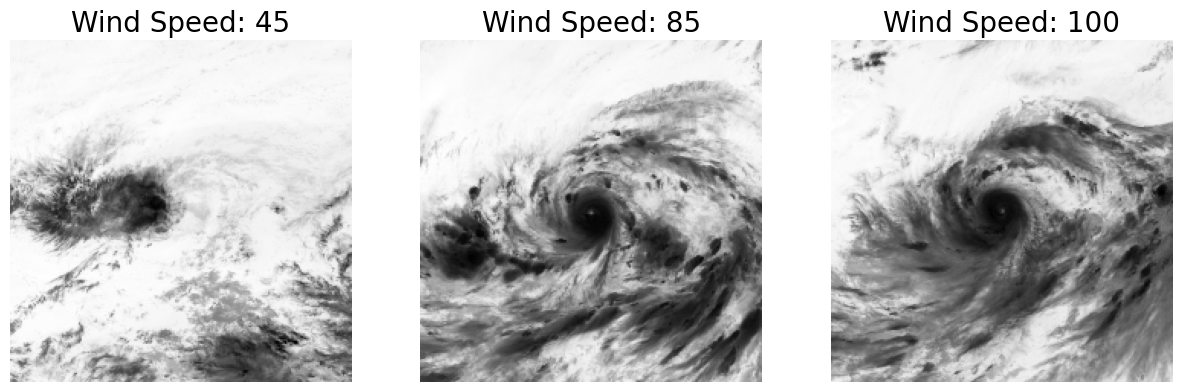

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


ranges = [CLASS_BINS["TS"], CLASS_BINS["H2"], CLASS_BINS["H3"]]

# # Create a subplot to display the images
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# for i, (min_speed, max_speed) in enumerate(ranges):
#     # Iterate through the dataset until you find a sample in the current wind speed range
#     for idx, sample in tqdm(enumerate(train_ds)):

#         if min_speed <= int(sample["target"]) < max_speed:
#             print(idx)
#             break

#     image = sample["input"].numpy().transpose(1, 2, 0) / 255

#     # Display the image and set the title to the target value
#     axes[i].imshow(image, cmap='gray')
#     axes[i].set_title(f'Wind Speed: {int(sample["target"])}')
#     axes[i].axis('off')

# plt.show()

# Define the indices of the samples you need
indices = [0, 2646, 2555]  # tropical cyclone
indices = [0, 171, 189]  # digital typhoon

# Create a subplot to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, index in enumerate(indices):
    # Retrieve the sample from the dataset
    sample = train_ds[index]

    image = sample["input"].numpy().transpose(1, 2, 0)[..., 0]

    # Display the image and set the title to the target value
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f'Wind Speed: {int(sample["target"])}', fontsize=20)
    axes[i].axis("off")

plt.show()

In [ ]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data


def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

In [ ]:
# train_df = retrieve_collection_df(train_ds)
# train_df["wind_speed"] = train_df["wind_speed"].astype(int)

train_df = train_ds.aux_df
train_df

,id,image_path,year,month,day,hour,grade,lat,lng,pressure,...,short50,dir30,long30,short30,landfall,intp,datetime,seq_id,hour_diff,wind_bins
12594,198702,1987041106-198702-GMS3-1.h5,1987,4,11,6,3,10.00,142.40,1000.0,...,0,9,150,150,0,0,1987-04-11 06:00:00,32,1.0,9
12595,198702,1987041107-198702-GMS3-1.h5,1987,4,11,7,3,10.09,142.31,1000.0,...,0,9,150,150,0,1,1987-04-11 07:00:00,33,1.0,9
12596,198702,1987041108-198702-GMS3-1.h5,1987,4,11,8,3,10.17,142.21,1000.0,...,0,9,150,150,0,1,1987-04-11 08:00:00,34,1.0,9
12597,198702,1987041109-198702-GMS3-1.h5,1987,4,11,9,3,10.24,142.11,1000.0,...,0,9,150,150,0,1,1987-04-11 09:00:00,35,1.0,9
12598,198702,1987041110-198702-GMS3-1.h5,1987,4,11,10,3,10.30,142.01,1000.0,...,0,9,150,150,0,1,1987-04-11 10:00:00,36,1.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189358,202225,2022121207-202225-HMW8-1.h5,2022,12,12,7,3,20.41,131.17,1002.7,...,0,8,150,90,0,1,2022-12-12 07:00:00,55,1.0,7
189359,202225,2022121208-202225-HMW8-1.h5,2022,12,12,8,3,20.40,131.30,1003.3,...,0,8,150,90,0,1,2022-12-12 08:00:00,56,1.0,7
189360,202225,2022121209-202225-HMW8-1.h5,2022,12,12,9,3,20.38,131.38,1004.0,...,0,8,150,90,0,1,2022-12-12 09:00:00,57,1.0,7
189361,202225,2022121210-202225-HMW8-1.h5,2022,12,12,10,3,20.36,131.44,1004.7,...,0,8,150,90,0,1,2022-12-12 10:00:00,58,1.0,7


In [ ]:
train_df["storm_category"] = pd.cut(
    train_df["wind"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
)
train_df

,id,image_path,year,month,day,hour,grade,lat,lng,pressure,...,dir30,long30,short30,landfall,intp,datetime,seq_id,hour_diff,wind_bins,storm_category
12594,198702,1987041106-198702-GMS3-1.h5,1987,4,11,6,3,10.00,142.40,1000.0,...,9,150,150,0,0,1987-04-11 06:00:00,32,1.0,9,TS
12595,198702,1987041107-198702-GMS3-1.h5,1987,4,11,7,3,10.09,142.31,1000.0,...,9,150,150,0,1,1987-04-11 07:00:00,33,1.0,9,TS
12596,198702,1987041108-198702-GMS3-1.h5,1987,4,11,8,3,10.17,142.21,1000.0,...,9,150,150,0,1,1987-04-11 08:00:00,34,1.0,9,TS
12597,198702,1987041109-198702-GMS3-1.h5,1987,4,11,9,3,10.24,142.11,1000.0,...,9,150,150,0,1,1987-04-11 09:00:00,35,1.0,9,TS
12598,198702,1987041110-198702-GMS3-1.h5,1987,4,11,10,3,10.30,142.01,1000.0,...,9,150,150,0,1,1987-04-11 10:00:00,36,1.0,9,TS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189358,202225,2022121207-202225-HMW8-1.h5,2022,12,12,7,3,20.41,131.17,1002.7,...,8,150,90,0,1,2022-12-12 07:00:00,55,1.0,7,TS
189359,202225,2022121208-202225-HMW8-1.h5,2022,12,12,8,3,20.40,131.30,1003.3,...,8,150,90,0,1,2022-12-12 08:00:00,56,1.0,7,TS
189360,202225,2022121209-202225-HMW8-1.h5,2022,12,12,9,3,20.38,131.38,1004.0,...,8,150,90,0,1,2022-12-12 09:00:00,57,1.0,7,TS
189361,202225,2022121210-202225-HMW8-1.h5,2022,12,12,10,3,20.36,131.44,1004.7,...,8,150,90,0,1,2022-12-12 10:00:00,58,1.0,7,TS


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 0, 'Wind Speed in knots')

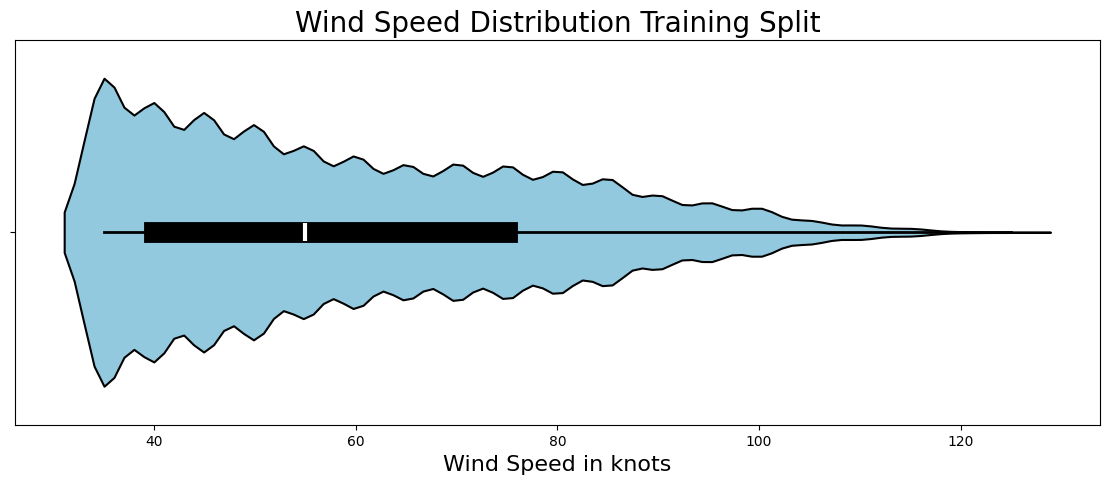

In [ ]:
sns.violinplot(
    x=train_df["wind"],
    orient="h",
    color="skyblue",
    inner_kws=dict(box_width=15, whis_width=2, color="black"),
    linewidth=1.5,
    linecolor="k",
)
plt.title(f"Wind Speed Distribution Training Split", fontsize=20)
plt.xlabel("Wind Speed in knots", fontsize=16)

Text(0.5, 1.0, 'Histogram of wind speeds')

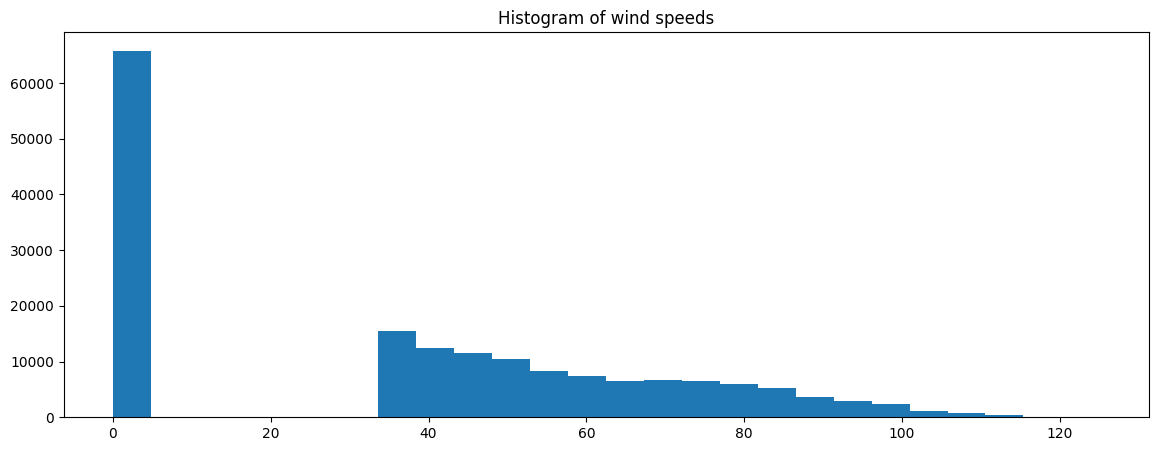

In [ ]:
plt.hist(train_df["wind"], bins=26)
plt.title("Histogram of wind speeds")

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


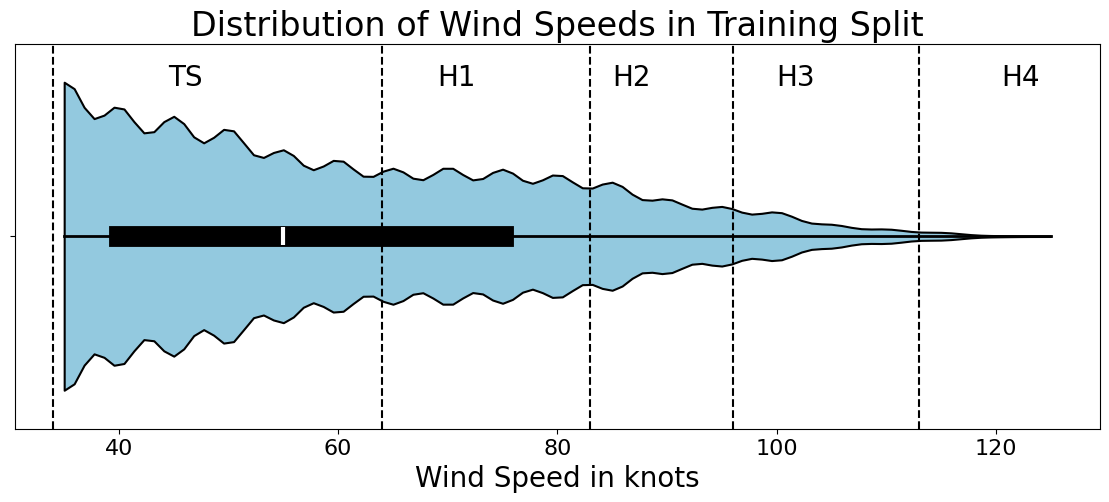

In [ ]:
import seaborn as sns


CLASS_BINS = {
    # "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    # "H5": (137, np.inf),
}

# CLASS_BINS["H5"] = (137, train_df["wind"].max())

# Create a horizontal violin plot of the wind_speed variable
sns.violinplot(
    x=train_df["wind"],
    orient="h",
    color="skyblue",
    inner_kws=dict(box_width=15, whis_width=2, color="black"),
    linewidth=1.5,
    linecolor="k",
    cut=0,
)

# Add vertical lines to represent the boundaries of the storm categories
# Add vertical lines to represent the boundaries of the storm categories
for category, (min_speed, max_speed) in CLASS_BINS.items():
    midpoint = (min_speed + max_speed) / 2 - 4
    plt.axvline(x=min_speed, color="black", linestyle="--")
    plt.text(
        midpoint,
        plt.gca().get_ylim()[1] * 0.9,
        category,
        color="black",
        fontsize=20,
        verticalalignment="top",
    )

# Add labels and title with larger font size
plt.xlabel("Wind Speed in knots", fontsize=20)
plt.title("Distribution of Wind Speeds in Training Split", fontsize=24)

# Increase the size of the x-ticks
plt.xticks(fontsize=16)

# Show the plot
plt.show()

In [ ]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["wind_speed"] = full_df["wind_speed"].astype(int)

full_df["storm_category"] = pd.cut(
    full_df["wind_speed"], bins=bins, labels=labels, right=False
)
full_df

## Wind Speed across splits

In [ ]:
fig, axs = plt.subplots(1)
sns.violinplot(full_df, x="split", y="wind_speed", ax=axs)
axs.set_title("Wind Speed for train and test split.")

## Wind Speed across categories

In [ ]:
# fig, axs = plt.subplots(1)
sns.catplot(full_df, kind="box", x="storm_category", y="wind_speed", hue="split")
plt.title("Boxplot of wind speeds across category and split")

In [ ]:
fig, axs = plt.subplots(1)
sns.countplot(full_df, x="storm_category", hue="split", ax=axs)
plt.title("Count samples per storm category")

In [ ]:
train_df["wind_speed"].astype(int).values

In [ ]:
np.save(
    "/p/project/hai_uqmethodbox/nils/lightning-uq-box/experiments/image-regression/configs/tropical_cyclone/target.npy",
    (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD,
)